In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from scipy import stats
import statsmodels.api as sm 


In [3]:
import pandas as pd

file_path = "SHCOMP_prices_mktcap_volum_shares - ELABORATED.xlsx"

sheets = pd.read_excel(file_path, sheet_name=None, decimal=".")

cleaned_sheets = {}

for name, df in sheets.items():
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
        df = df.dropna(subset=["Date"])
        df = df.sort_values(by="Date")
        df = df.set_index("Date")
    cleaned_sheets[name] = df

S_C_I = cleaned_sheets["S_C_I"]
stocks = cleaned_sheets["com_prices"]
stocks_d_mktcap = cleaned_sheets["comp_marketcap"]
stocks_d_volume = cleaned_sheets["comp_volume"]
stocks_d_shares_outstanding= cleaned_sheets["comp_shares outstanding"]


In [4]:
components = sheets["Components"].copy()
print(list(components.columns))

stocks_Sector_Industry= components[['Ticker', 'GICS Sector\n', 'GICS Ind Name\n',]]
stocks_Sector_Industry = stocks_Sector_Industry.rename(columns={
    'GICS Sector\n': 'Sector',
    'GICS Ind Name\n': 'Industry'
})
display(stocks_Sector_Industry)


['Ticker', 'Name', 'Weight', 'Shares', 'Price', 'GICS Ind Grp Name\n', 'ISIN\n', 'GICS Ind Name\n', 'GICS Sector\n']


,Ticker,Sector,Industry
0,601288 CH Equity,Financials,Banks
1,601398 CH Equity,Financials,Banks
2,600519 CH Equity,Consumer Staples,Beverages
3,601857 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
4,601988 CH Equity,Financials,Banks
...,...,...,...
2229,900913 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
2230,900921 CH Equity,Materials,Chemicals
2231,900915 CH Equity,Consumer Discretionary,Leisure Products
2232,900922 CH Equity,Consumer Discretionary,"Textiles, Apparel & Luxury Goods"


In [5]:
stocks.columns = stocks.columns.str.strip()
stocks_Sector_Industry['Ticker'] = stocks_Sector_Industry['Ticker'].astype(str).str.strip()

sector_map = stocks_Sector_Industry.set_index('Ticker')['Sector'].to_dict()
industry_map = stocks_Sector_Industry.set_index('Ticker')['Industry'].to_dict()

firm_data = pd.DataFrame(index=stocks.columns)
firm_data['Sector'] = firm_data.index.map(sector_map)
firm_data['Industry'] = firm_data.index.map(industry_map)

missing = firm_data[firm_data['Sector'].isna()].index.tolist()
print(f"Matched tickers: {firm_data['Sector'].notna().sum()} / {len(firm_data)}")
if missing:
    print(f"Missing: {len(missing)}")
    print(missing[:10])

display(firm_data.head(10))


Matched tickers: 999 / 999


,Sector,Industry
601288 CH Equity,Financials,Banks
601398 CH Equity,Financials,Banks
600519 CH Equity,Consumer Staples,Beverages
601857 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
601988 CH Equity,Financials,Banks
601138 CH Equity,Information Technology,"Electronic Equipment, Instruments & Components"
600036 CH Equity,Financials,Banks
601628 CH Equity,Financials,Insurance
601088 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
600900 CH Equity,Utilities,Independent Power and Renewable Electricity Pr...


In [6]:
EEM= yf.download('EEM', start='2020-01-01', end='2025-10-10', auto_adjust=True, progress=False)['Close']

In [7]:
EVENT_DATE = pd.Timestamp('2024-09-24')

In [8]:

START, END = 250, 20 
EV_PRE, EV_POST    = 1, 3     
t0 = EVENT_DATE

est_start = t0 - pd.Timedelta(days=START)
est_end   = t0 - pd.Timedelta(days=END)
ev_start  = t0 - pd.Timedelta(days=EV_PRE)
ev_end    = t0 + pd.Timedelta(days=EV_POST)

In [77]:
stocks.index = pd.to_datetime(stocks.index)
stocks_ante= stocks.loc[EVENT_DATE - pd.Timedelta(days=START) : EVENT_DATE - pd.Timedelta(days=END)]
stocks_post= stocks.loc[EVENT_DATE: ]
vol_ante= stocks_d_volume.loc[EVENT_DATE - pd.Timedelta(days=START) : EVENT_DATE - pd.Timedelta(days=END)]
vol_post= stocks_d_volume.loc[EVENT_DATE: ]

In [10]:
# Forza conversione dell'indice in datetime corretto
stocks.index = pd.to_datetime(stocks.index, errors='coerce', dayfirst=True)
stocks = stocks.sort_index()
print(stocks.index.min(), stocks.index.max())

2022-09-01 00:00:00 2025-10-17 00:00:00


In [11]:

period_start, period_end = est_start, est_end

mcap_slice = stocks_d_mktcap.loc[period_start:period_end].apply(pd.to_numeric, errors='coerce').ffill()
daily_w = mcap_slice.div(mcap_slice.sum(axis=1), axis=0)
w_mean_pre = daily_w.mean(axis=0).dropna()
w_mean_pre = w_mean_pre / w_mean_pre.sum()
w_mean_pre.name = f"w_mean_{period_start.date()}_{period_end.date()}"

# opzionale: occhiata ai top pesi medi
display(w_mean_pre.sort_values(ascending=False).head(10))


600519 CH Equity    0.041829
601398 CH Equity    0.038238
601857 CH Equity    0.034579
601288 CH Equity    0.030948
600941 CH Equity    0.030002
601939 CH Equity    0.025538
601988 CH Equity    0.025449
600938 CH Equity    0.018086
600036 CH Equity    0.017037
601088 CH Equity    0.015965
Name: w_mean_2024-01-18_2024-09-04, dtype: float64

In [12]:

mcap_slice = stocks_d_mktcap.loc[t0:].apply(pd.to_numeric, errors='coerce').ffill()
daily_w = mcap_slice.div(mcap_slice.sum(axis=1), axis=0)
w_mean_post = daily_w.mean(axis=0).dropna()
w_mean_post = w_mean_post / w_mean_post.sum()
w_mean_post.name = f"w_mean_{period_start.date()}_{period_end.date()}"

# opzionale: occhiata ai top pesi medi
display(w_mean_post.sort_values(ascending=False).head(10))


601398 CH Equity    0.041043
601288 CH Equity    0.034028
600519 CH Equity    0.033748
600941 CH Equity    0.029214
601939 CH Equity    0.029148
601988 CH Equity    0.026818
601857 CH Equity    0.026415
600036 CH Equity    0.018653
601628 CH Equity    0.017079
601318 CH Equity    0.016331
Name: w_mean_2024-01-18_2024-09-04, dtype: float64

In [13]:

period_start, period_end = ev_start, ev_end

mcap_slice = stocks_d_mktcap.loc[period_start:period_end].apply(pd.to_numeric, errors='coerce').ffill()
daily_w = mcap_slice.div(mcap_slice.sum(axis=1), axis=0)
w_mean_ev = daily_w.mean(axis=0).dropna()
w_mean_ev = w_mean_ev / w_mean_ev.sum()
w_mean_ev.name = f"w_mean_{period_start.date()}_{period_end.date()}"

# opzionale: occhiata ai top pesi medi
display(w_mean_ev.sort_values(ascending=False).head(10))

601398 CH Equity    0.041454
600519 CH Equity    0.037657
601288 CH Equity    0.034065
601857 CH Equity    0.030591
600941 CH Equity    0.030276
601939 CH Equity    0.028605
601988 CH Equity    0.027307
601628 CH Equity    0.018377
600938 CH Equity    0.017799
600036 CH Equity    0.017674
Name: w_mean_2024-09-23_2024-09-27, dtype: float64

# **HP1**

# *Shanghai Composite Index Abnormal returns*


[SCI] Event window [-1,+3] — full table:


,r_S_C_I,r_hat,AR,t_AR,CAR,t_CAR
Date,,,,,,
2024-09-23,0.003633,0.002537,0.001096,0.129782,0.001096,NaN
2024-09-24,0.043632,0.011909,0.031722,3.757380,0.032818,NaN
2024-09-25,0.011266,-0.004143,0.015409,1.825159,0.048227,NaN
2024-09-26,0.038741,0.012809,0.025932,3.071524,0.074159,NaN
2024-09-27,0.028413,-0.000987,0.029400,3.482285,0.103558,6.068174



t-CAR[-1,+1] = 3.947 ***
t-CAR[-1,+3] = 6.068 ***


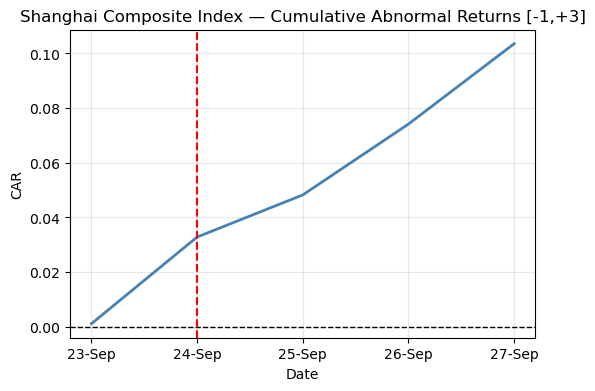

In [14]:

r_S_C_I = np.log(S_C_I / S_C_I.shift(1)).dropna()
r_EEM   = np.log(EEM / EEM.shift(1)).dropna()

ret_df = pd.concat([r_S_C_I, r_EEM], axis=1).dropna()
ret_df.columns = ['r_S_C_I', 'r_EEM']

est_df = ret_df.loc[est_start:est_end]
ev_df  = ret_df.loc[ev_start:ev_end]

X_est = sm.add_constant(est_df['r_EEM'])
y_est = est_df['r_S_C_I']
mm = sm.OLS(y_est, X_est).fit()

alpha = mm.params['const']
beta  = mm.params['r_EEM']
sigma_eps = mm.resid.std(ddof=int(mm.df_model)+1)

X_ev = sm.add_constant(ev_df['r_EEM'])
r_hat = mm.predict(X_ev)
AR_idx = ev_df['r_S_C_I'] - r_hat
CAR_idx = AR_idx.cumsum()
t_AR = AR_idx / sigma_eps

def tstat_car(AR_series, start, end, sigma):
    win = AR_series.loc[start:end]
    n = len(win)
    if n < 1 or sigma is None or sigma <= 0:
        return np.nan
    return win.sum() / (sigma * np.sqrt(n))

t_CAR_01 = tstat_car(AR_idx, t0, t0 + pd.Timedelta(days=1), sigma_eps)
t_CAR_03 = tstat_car(AR_idx, t0, t0 + pd.Timedelta(days=3), sigma_eps)

out_idx = pd.DataFrame({
    'r_S_C_I': ev_df['r_S_C_I'],
    'r_hat': r_hat,
    'AR': AR_idx,
    't_AR': t_AR,
    'CAR': CAR_idx
})

out_idx['t_CAR'] = np.nan
out_idx.loc[out_idx.index.max(), 't_CAR'] = t_CAR_03

def stars(t):
    if pd.isna(t): return ''
    at = abs(t)
    return '***' if at >= 2.58 else '**' if at >= 1.96 else '*' if at >= 1.65 else ''

print("\n[SCI] Event window [-1,+3] — full table:")
display(out_idx)

print(f"\nt-CAR[-1,+1] = {t_CAR_01:.3f} {stars(t_CAR_01)}")
print(f"t-CAR[-1,+3] = {t_CAR_03:.3f} {stars(t_CAR_03)}")

plt.figure(figsize=(6,4))
plt.plot(CAR_idx, color='steelblue', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Shanghai Composite Index — Cumulative Abnormal Returns [-1,+3]")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.axvline(t0, color='r', ls='--', label='Event day(24/09/2024)')
plt.ylabel("CAR")
plt.grid(alpha=0.3)
plt.show()


# *DIAGNOSTICA DEI DATI*

In [15]:
# ================================
# SCI — Check 1: copertura temporale e finestre
# Verifica lunghezze e range delle serie e delle finestre usate.
# ================================
r_S_C_I = np.log(S_C_I / S_C_I.shift(1)).dropna()
r_EEM   = np.log(EEM   / EEM.shift(1)).dropna()
ret_df  = pd.concat([r_S_C_I, r_EEM], axis=1).dropna()
ret_df.columns = ['r_S_C_I','r_EEM']

est_df = ret_df.loc[est_start:est_end]
ev_df  = ret_df.loc[ev_start:ev_end]

print("Returns range      :", ret_df.index.min().date(), "→", ret_df.index.max().date(), "| N =", len(ret_df))
print("Estimation window  :", est_start.date(), "→", est_end.date(),  "| N =", len(est_df))
print("Event window       :", ev_start.date(),  "→", ev_end.date(),   "| N =", len(ev_df))
print("NaN in estimation? :", est_df.isna().any().any())
print("NaN in event?      :", ev_df.isna().any().any())


Returns range      : 2020-01-03 → 2025-10-09 | N = 1345
Estimation window  : 2024-01-18 → 2024-09-04 | N = 147
Event window       : 2024-09-23 → 2024-09-27 | N = 5
NaN in estimation? : False
NaN in event?      : False


alpha = -0.000285  | beta = 0.364  | R² = 0.126  | N = 147


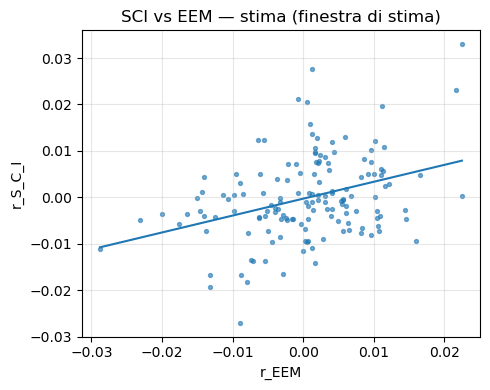

In [16]:
# ================================
# SCI — Check 2: Market Model (α, β, R²) sulla finestra di stima
# Stima OLS r_SCI = α + β r_EEM e stampa parametri chiave.
# ================================
X = sm.add_constant(est_df['r_EEM'])
y = est_df['r_S_C_I']
mm_diag = sm.OLS(y, X).fit()

alpha = mm_diag.params['const']
beta  = mm_diag.params['r_EEM']
R2    = mm_diag.rsquared
N     = int(mm_diag.nobs)

print(f"alpha = {alpha:.6f}  | beta = {beta:.3f}  | R² = {R2:.3f}  | N = {N}")

# (opzionale) scatter r_EEM vs r_S_C_I con retta stimata, solo per un colpo d’occhio
plt.figure(figsize=(5,4))
plt.scatter(est_df['r_EEM'], est_df['r_S_C_I'], s=8, alpha=0.6)
xline = np.linspace(est_df['r_EEM'].min(), est_df['r_EEM'].max(), 100)
plt.plot(xline, alpha + beta*xline)
plt.title("SCI vs EEM — stima (finestra di stima)")
plt.xlabel("r_EEM"); plt.ylabel("r_S_C_I")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Residui: mean = 9.44067e-20 | std = 0.00841364 | Durbin–Watson = 1.826
Jarque–Bera: JB = 6.65 (p = 0.036)


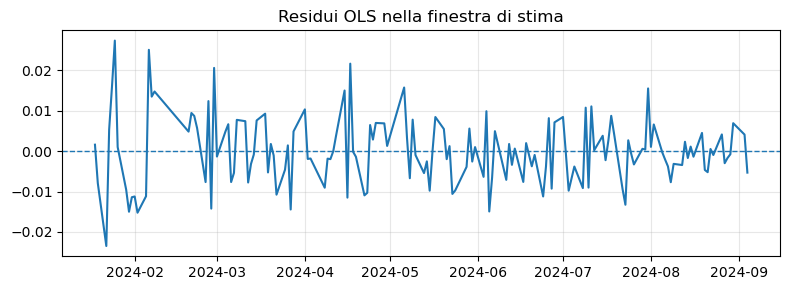

In [17]:
# ================================
# SCI — Check 3: diagnostica residui nella finestra di stima
# Media≈0, deviazione std, autocorrelazione (DW), normalità (Jarque–Bera).
# ================================
resid = mm_diag.resid
mu = resid.mean()
sd = resid.std(ddof=1)
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(resid)
jb_stat, jb_p = stats.jarque_bera(resid)

print(f"Residui: mean = {mu:.6g} | std = {sd:.6g} | Durbin–Watson = {dw:.3f}")
print(f"Jarque–Bera: JB = {jb_stat:.2f} (p = {jb_p:.3f})")

# (opzionale) andamento residui nel tempo
plt.figure(figsize=(8,3))
plt.plot(est_df.index, resid)
plt.axhline(0, linestyle='--', linewidth=1)
plt.title("Residui OLS nella finestra di stima")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# ================================
# SCI — Check 4: ricostruzione AR / CAR nella finestra evento
# Ricompone r_hat, AR e CAR e confronta con i tuoi risultati.
# ================================
X_ev  = sm.add_constant(ev_df['r_EEM'])
r_hat = mm_diag.predict(X_ev)
AR    = ev_df['r_S_C_I'] - r_hat
CAR   = AR.cumsum()

print("CAR[-1,+3] =", float(CAR.iloc[-1]))

# Tabellina rapida (prime righe)
out_check = pd.DataFrame({
    'r_S_C_I': ev_df['r_S_C_I'],
    'r_hat'  : r_hat,
    'AR'     : AR,
    'CAR'    : CAR
})
display(out_check.head())


CAR[-1,+3] = 0.1035580819024407


,r_S_C_I,r_hat,AR,CAR
Date,,,,
2024-09-23,0.003633,0.002537,0.001096,0.001096
2024-09-24,0.043632,0.011909,0.031722,0.032818
2024-09-25,0.011266,-0.004143,0.015409,0.048227
2024-09-26,0.038741,0.012809,0.025932,0.074159
2024-09-27,0.028413,-0.000987,0.029400,0.103558


In [19]:
# ================================
# SCI — Check 5: t-stat di controllo per CAR[-1,+1] e [-1,+3]
# Stessa formula che usi nel blocco principale.
# ================================
sigma_eps = resid.std(ddof=int(mm_diag.df_model)+1)

def tstat_car_simple(AR_series, start, end, sigma):
    win = AR_series.loc[start:end]
    n = len(win)
    if n < 1 or sigma is None or sigma <= 0:
        return np.nan
    return win.sum() / (sigma * np.sqrt(n))

t_CAR_01 = tstat_car_simple(AR, t0, t0 + pd.Timedelta(days=1), sigma_eps)
t_CAR_03 = tstat_car_simple(AR, t0, t0 + pd.Timedelta(days=3), sigma_eps)

def stars(t):
    if pd.isna(t): return ''
    a = abs(t)
    return '***' if a>=2.58 else '**' if a>=1.96 else '*' if a>=1.65 else ''

print(f"t-CAR[-1,+1] = {t_CAR_01:.3f} {stars(t_CAR_01)}")
print(f"t-CAR[-1,+3] = {t_CAR_03:.3f} {stars(t_CAR_03)}")


t-CAR[-1,+1] = 3.947 ***
t-CAR[-1,+3] = 6.068 ***


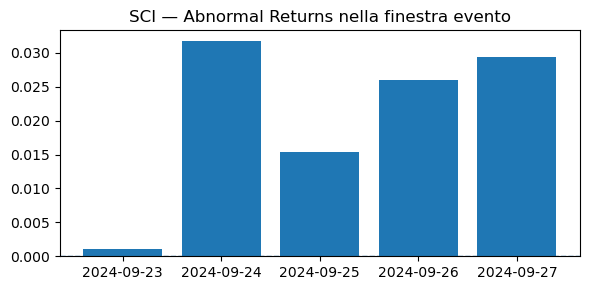

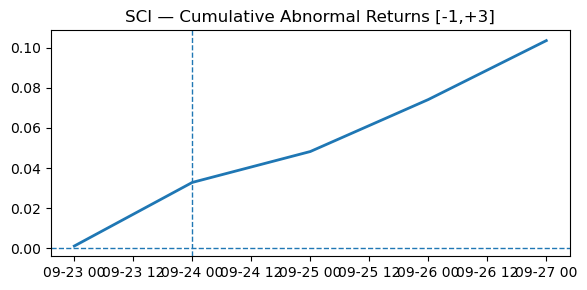

In [20]:
# ================================
# SCI — Check 6: grafici rapidi AR e CAR sull’evento
# Serve a vedere a colpo d’occhio se la dinamica ha senso economico.
# ================================
plt.figure(figsize=(6,3))
plt.bar(AR.index, AR.values)
plt.axhline(0, linestyle='--', linewidth=1)
plt.title("SCI — Abnormal Returns nella finestra evento")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(CAR, linewidth=2)
plt.axhline(0, linestyle='--', linewidth=1)
plt.axvline(t0, linestyle='--', linewidth=1)
plt.title("SCI — Cumulative Abnormal Returns [-1,+3]")
plt.tight_layout()
plt.show()


# *Sectors Abnormal Returns*


=== Settorial CAR [-1,+3] (benchmark: SCI) ===


,"CAR[-1,+3]","t-CAR[-1,+3]",sig
Consumer Staples,0.141908,6.158710,***
Financials,0.048553,2.770588,***
Utilities,0.010979,0.514033,
Real Estate,-0.002808,-0.091592,
Communication Services,-0.013956,-0.591512,
Energy,-0.015547,-0.452849,
Health Care,-0.015919,-0.629242,
Industrials,-0.027347,-2.776967,***
Materials,-0.027508,-1.644415,
Consumer Discretionary,-0.031001,-1.668461,*


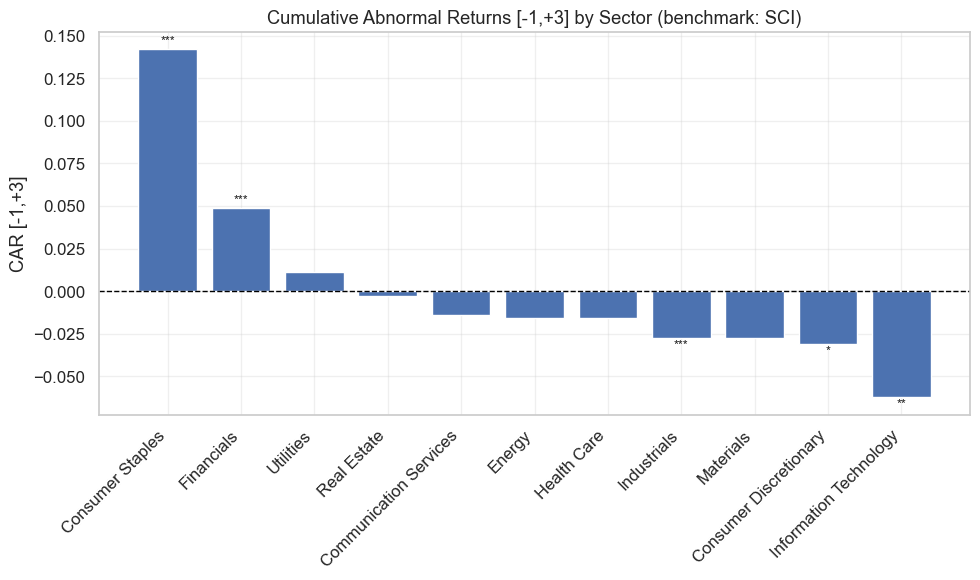

In [24]:

# 1) Rendimenti (lascia NaN dove mancano i prezzi)
r_stocks = np.log(stocks / stocks.shift(1)).replace([np.inf, -np.inf], np.nan)
r_S_C_I  = np.log(S_C_I / S_C_I.shift(1)).dropna()

# 2) Pesi VW: ultimo market cap valido <= evento
mcap_t0 = stocks_d_mktcap.loc[:EVENT_DATE].ffill().iloc[-1]
mcap_t0 = pd.to_numeric(mcap_t0, errors='coerce')

# 3) Loop settori: market model, AR, CAR, t-CAR
CAR_sector = pd.DataFrame(columns=['CAR[-1,+3]', 't-CAR[-1,+3]'])
sectors = firm_data['Sector'].dropna().unique()

for sec in sectors:
    tickers = firm_data[firm_data['Sector'] == sec].index.intersection(r_stocks.columns)
    if len(tickers) < 5:
        continue

    w = mcap_t0[tickers].astype(float).dropna()
    if len(w) < 5:
        continue

    X = r_stocks[w.index]                                       # rendimenti dei titoli del settore (con NaN)
    W = pd.DataFrame(1.0, index=X.index, columns=X.columns).mul(w, axis=1)
    W = W.where(~X.isna())                                      # azzera peso se il ritorno è NaN quel giorno
    num = (X * W).sum(axis=1)                                   # somma pesata ignorando i NaN
    den = W.sum(axis=1)                                         # somma pesi disponibili quel giorno
    r_sector = (num / den).fillna(0)

    ret_df = pd.concat([r_sector, r_S_C_I], axis=1).dropna()
    ret_df.columns = ['r_sector', 'r_S_C_I']

    est_df = ret_df.loc[est_start:est_end]
    ev_df  = ret_df.loc[ev_start:ev_end]
    if len(est_df) < 30 or len(ev_df) < 2:
        continue

    X_est = sm.add_constant(est_df['r_S_C_I'])
    y_est = est_df['r_sector']
    mm = sm.OLS(y_est, X_est).fit()
    sigma_eps = mm.resid.std(ddof=int(mm.df_model)+1)

    X_ev = sm.add_constant(ev_df['r_S_C_I'])
    r_hat = mm.predict(X_ev)
    AR = ev_df['r_sector'] - r_hat
    CAR = AR.cumsum()

    n = len(AR)
    if sigma_eps > 0 and n > 0:
        t_CAR = CAR.iloc[-1] / (sigma_eps * np.sqrt(n))
    else:
        t_CAR = np.nan

    CAR_sector.loc[sec] = [CAR.iloc[-1], t_CAR]

def stars(t):
    if pd.isna(t): return ''
    a = abs(t)
    return '***' if a >= 2.58 else '**' if a >= 1.96 else '*' if a >= 1.65 else ''

CAR_sector['sig'] = CAR_sector['t-CAR[-1,+3]'].apply(stars)
CAR_sector = CAR_sector.sort_values('CAR[-1,+3]', ascending=False)

print("\n=== Settorial CAR [-1,+3] (benchmark: SCI) ===")
display(CAR_sector)

# 4) Grafico a barre con asterischi
plt.figure(figsize=(10,6))
plt.bar(CAR_sector.index, CAR_sector['CAR[-1,+3]'])
for i, (sec, row) in enumerate(CAR_sector.iterrows()):
    y = row['CAR[-1,+3]']
    label = row['sig']
    if label:
        plt.text(i, y + np.sign(y)*0.001, label, ha='center', va='bottom' if y>=0 else 'top', fontsize=9)
plt.axhline(0, linestyle='--', linewidth=1, color='black')
plt.title("Cumulative Abnormal Returns [-1,+3] by Sector (benchmark: SCI)")
plt.ylabel("CAR [-1,+3]")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()






=== Market CAR (VW from sectors) ===


,Weight,"CAR[-1,+3]",Contribution
Financials,31.02%,0.0486,0.0151
Consumer Staples,6.77%,0.1419,0.0096
Utilities,5.02%,0.0110,0.0006
Real Estate,1.15%,-0.0028,-0.0000
Communication Services,5.36%,-0.0140,-0.0007
Health Care,4.71%,-0.0159,-0.0007
Consumer Discretionary,4.70%,-0.0310,-0.0015
Energy,10.62%,-0.0155,-0.0017
Materials,7.66%,-0.0275,-0.0021
Industrials,13.48%,-0.0273,-0.0037



Market CAR [-1,+3] (VW): 0.0089    t = 1.148    (n=5,  σ_mkt=0.00346)


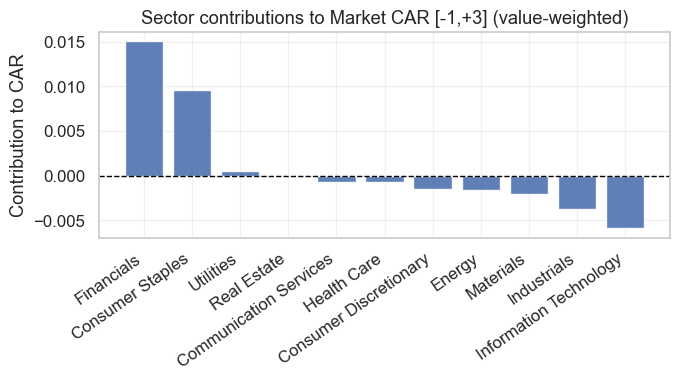

In [25]:
# ===== Market CAR (value-weighted) from sectors + significance =====

# 1) Pesi per settore (evento): uso w_mean_ev se c'è, altrimenti mcap_t0
try:
    firm_w = w_mean_ev.reindex(firm_data.index).astype(float)
except NameError:
    firm_w = pd.to_numeric(mcap_t0.reindex(firm_data.index), errors='coerce')

firm_w = firm_w.fillna(0)
sector_w = firm_data['Sector'].to_frame('Sector').join(firm_w.rename('w'))
sector_w = sector_w.groupby('Sector')['w'].sum().reindex(CAR_sector.index).fillna(0.0)
sector_w = sector_w / sector_w.sum()

# 2) CAR di mercato come media ponderata dei CAR settoriali
CAR_s = CAR_sector['CAR[-1,+3]'].astype(float)
CAR_mkt = float((CAR_s * sector_w).sum())

# 3) Stima sigma per settore sulla finestra di stima (se non già salvata)
sigma_by_sector = {}
for sec in CAR_sector.index:
    tickers = firm_data.index[firm_data['Sector'].eq(sec)].intersection(r_stocks.columns)
    w0 = firm_w.reindex(tickers).astype(float).replace([np.inf, -np.inf], np.nan).dropna()
    if len(w0) < 5:
        sigma_by_sector[sec] = np.nan
        continue
    w0 = w0 / w0.sum()
    r_sector = (r_stocks[w0.index] * w0).sum(axis=1)
    ret_df = pd.concat([r_sector, r_S_C_I], axis=1).dropna()
    ret_df.columns = ['r_sector', 'r_S_C_I']
    est_df = ret_df.loc[est_start:est_end]
    if len(est_df) <= 30:
        sigma_by_sector[sec] = np.nan
        continue
    mm = sm.OLS(est_df['r_sector'], sm.add_constant(est_df['r_S_C_I'])).fit()
    sigma_by_sector[sec] = float(mm.resid.std(ddof=int(mm.df_model)+1))

# 4) t-stat del CAR di mercato
#    var(AR_mkt) ≈ Σ w_s^2 σ_s^2  →  t = CAR / (sqrt(Σ w_s^2 σ_s^2) * sqrt(n))
sigma2_mkt = 0.0
for sec in CAR_sector.index:
    ws = float(sector_w.get(sec, 0.0))
    ss = sigma_by_sector.get(sec, np.nan)
    if not pd.isna(ss):
        sigma2_mkt += (ws**2) * (ss**2)

sigma_mkt = np.sqrt(sigma2_mkt) if sigma2_mkt > 0 else np.nan
n = len(r_S_C_I.loc[ev_start:ev_end])  # giorni effettivi nell'evento
t_CAR_mkt = CAR_mkt / (sigma_mkt * np.sqrt(n)) if (n > 0 and not np.isnan(sigma_mkt)) else np.nan

def stars(t):
    if pd.isna(t): return ''
    a = abs(t)
    return '***' if a>=2.58 else '**' if a>=1.96 else '*' if a>=1.65 else ''

# 5) Tabellina di presentazione (contributi per settore)
contrib = (CAR_s * sector_w).rename('Contribution')
summary = pd.DataFrame({
    'Weight': sector_w,
    'CAR[-1,+3]': CAR_s,
    'Contribution': contrib
}).sort_values('Contribution', ascending=False)

print("\n=== Market CAR (VW from sectors) ===")
display(summary.style.format({'Weight':'{:.2%}','CAR[-1,+3]':'{:.4f}','Contribution':'{:.4f}'}))

print(f"\nMarket CAR [-1,+3] (VW): {CAR_mkt:.4f}    t = {t_CAR_mkt:.3f} {stars(t_CAR_mkt)}   "
      f"(n={n},  σ_mkt={sigma_mkt:.5f})")

# 6) Grafico gradevole dei contributi
plt.figure(figsize=(7,4))
plt.bar(summary.index, summary['Contribution'], alpha=0.9)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Sector contributions to Market CAR [-1,+3] (value-weighted)")
plt.ylabel("Contribution to CAR")
plt.xticks(rotation=35, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# *diagnostica dei dati*

In [26]:
#DIAGNOSTICA DEI DATI

# ================================
# 1) CHECK TEMPORALE DI BASE
# Scopo: verifica che le finestre di stima/evento abbiano dati,
#        e che l’intero pannello r_stocks copra il periodo giusto.
# ================================
print("Estimation window:", est_start.date(), "→", est_end.date(), "len(est_df) =", len(est_df))
print("Event window     :", ev_start.date(), "→", ev_end.date(), "len(ev_df)  =", len(ev_df))
print("r_stocks range   :", r_stocks.index.min().date(), "→", r_stocks.index.max().date())


Estimation window: 2024-01-18 → 2024-09-04 len(est_df) = 153
Event window     : 2024-09-23 → 2024-09-27 len(ev_df)  = 5
r_stocks range   : 2022-09-01 → 2025-10-17


In [27]:
# =====================================
# 2) COPERTURA SETTORI
# Scopo: per ogni settore, quanti ticker rientrano effettivamente nell’analisi
# (cioè presenti sia in firm_data sia in r_stocks).
# =====================================
sectors = firm_data['Sector'].dropna().unique()
for sec in sectors:
    # tickers presenti nel settore e anche nelle colonne dei rendimenti
    tickers = firm_data[firm_data['Sector']==sec].index.intersection(r_stocks.columns)
    print(f"{sec:<25}  tickers presi: {len(tickers)}")


Financials                 tickers presi: 79
Consumer Staples           tickers presi: 49
Energy                     tickers presi: 35
Information Technology     tickers presi: 201
Utilities                  tickers presi: 45
Materials                  tickers presi: 135
Communication Services     tickers presi: 31
Health Care                tickers presi: 93
Industrials                tickers presi: 232
Consumer Discretionary     tickers presi: 72
Real Estate                tickers presi: 27


In [28]:
# =====================================
# 3) DIAGNOSTICA MARKET CAP (pesi VW)
# Scopo: controlla che i pesi siano numerici e senza buchi gravi.
#        mcap_t0 = ultimo market cap valido <= EVENT_DATE
# =====================================
print("Statistiche market cap al t0 (numeriche):")
print(pd.to_numeric(mcap_t0, errors='coerce').describe())
print("Titoli con NaN nei market cap:", pd.to_numeric(mcap_t0, errors='coerce').isna().sum())


Statistiche market cap al t0 (numeriche):
count       998.000000
mean       6707.106974
std       21787.471456
min         160.762200
25%        1215.934050
50%        2018.345000
75%        4068.223850
max      282446.219600
Name: 2024-09-24 00:00:00, dtype: float64
Titoli con NaN nei market cap: 1


In [29]:
# =====================================
# 4) ISPEZIONE DI UN SETTORE SPECIFICO (esempio: Financials)
# Scopo: vedere i rendimenti aggregati del settore nel periodo di interesse
#        e il range temporale effettivo.
# Nota: qui uso pesi fissi (normalizzati) solo per ispezione veloce.
# =====================================
sec = 'Financials'  # <— cambia se vuoi controllare un altro settore
tickers = firm_data[firm_data['Sector']==sec].index.intersection(r_stocks.columns)

# pesi fissi normalizzati (solo per check)
w0 = pd.to_numeric(mcap_t0[tickers], errors='coerce').dropna()
w0 = w0 / w0.sum()

# rendimento settoriale value-weighted semplice (senza rinormalizzazione giornaliera)
r_sector_quick = (r_stocks[w0.index] * w0).sum(axis=1)

# mostro le prime righe nella fascia estesa (stima + evento)
display(r_sector_quick.loc[est_start:ev_end].head(10))
print("Date range settore:", r_sector_quick.index.min().date(), "→", r_sector_quick.index.max().date())


Date
2024-01-18    0.003541
2024-01-19   -0.001860
2024-01-22   -0.002947
2024-01-23    0.005221
2024-01-24    0.026818
2024-01-25    0.016737
2024-01-26    0.012192
2024-01-29    0.005416
2024-01-30   -0.010913
2024-01-31    0.004927
dtype: float64

Date range settore: 2022-09-01 → 2025-10-17


In [30]:
# =====================================
# 5) MINI-REPORT OLS PER SETTORE (alpha, beta, R^2)
# Scopo: stimare il market model r_sector ~ alpha + beta * r_S_C_I
#        su finestra di stima per tutti i settori calcolati nei CAR.
#        Utile per capire “quanto” ogni settore si muove col mercato.
# =====================================
results = []
for sec in CAR_sector.index:  # uso i settori per i quali hai già calcolato i CAR
    tickers = firm_data[firm_data['Sector']==sec].index.intersection(r_stocks.columns)
    # VW semplice per diagnostica (coerente con il punto 4)
    w0 = pd.to_numeric(mcap_t0[tickers], errors='coerce').dropna()
    if len(w0) < 5:
        continue
    w0 = w0 / w0.sum()
    r_sector = (r_stocks[w0.index] * w0).sum(axis=1)

    # dataset per la regressione
    ret_df = pd.concat([r_sector, r_S_C_I], axis=1).dropna()
    ret_df.columns = ['r_sector','r_S_C_I']
    est_df = ret_df.loc[est_start:est_end]
    if len(est_df) <= 30:
        continue

    # stima OLS e raccolta diagnostica
    X = sm.add_constant(est_df['r_S_C_I'])
    y = est_df['r_sector']
    mm = sm.OLS(y, X).fit()
    results.append([sec, mm.params.get('const', np.nan), mm.params.get('r_S_C_I', np.nan), mm.rsquared])

diag_ols = pd.DataFrame(results, columns=['Sector','alpha','beta','R2']).round(4).sort_values('R2', ascending=False)
display(diag_ols)


,Sector,alpha,beta,R2
7,Industrials,0.0003,1.1426,0.8487
8,Materials,0.0003,1.2581,0.7021
9,Consumer Discretionary,0.0001,1.1946,0.6327
10,Information Technology,-0.0002,1.6873,0.6225
3,Real Estate,-0.0006,1.5187,0.5055
6,Health Care,-0.0004,1.1707,0.4716
0,Consumer Staples,-0.0007,0.7475,0.3049
1,Financials,0.0009,0.4281,0.1992
4,Communication Services,0.0006,0.5211,0.1690
2,Utilities,0.0009,0.4348,0.1473


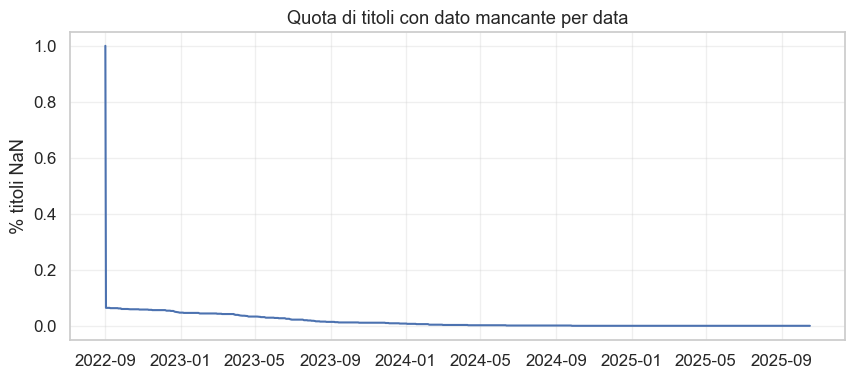

In [31]:
# =====================================
# 6) HEATMAP DEI BUCHI (quota di NaN per data)
# Scopo: capire se ci sono periodi con molti dati mancanti nel pannello titoli.
#        Valore = % di colonne con NaN in quella data.
# =====================================
na_ratio = r_stocks.isna().mean(axis=1)  # percentuale di titoli con NaN per ogni data
plt.figure(figsize=(10,4))
plt.plot(na_ratio.index, na_ratio.values)
plt.title("Quota di titoli con dato mancante per data")
plt.ylabel("% titoli NaN")
plt.grid(alpha=0.3)
plt.show()


In [32]:
print(len(firm_data.index.intersection(r_stocks.columns)))
print(r_stocks.index.min(), r_stocks.index.max())
print(est_start, est_end)
print(stocks_d_mktcap.loc[:EVENT_DATE].iloc[-1].isna().sum())


999
2022-09-01 00:00:00 2025-10-17 00:00:00
2024-01-18 00:00:00 2024-09-04 00:00:00
1


In [33]:
# =====================================
# 7) CHECK “DROPNA IMPATTO”
# Scopo: mostra quanto sarebbe devastante usare .dropna() globale sui rendimenti,
#        così eviti di perderti date utili.
# =====================================
tmp = np.log(stocks / stocks.shift(1))
print("Righe totali:", len(tmp))
print("Righe perse con dropna() globale:", len(tmp) - len(tmp.dropna()))
print("Date con ≥1 NaN:", tmp.isna().any(axis=1).sum())
print("Colonne con ≥1 NaN:", tmp.isna().any(axis=0).sum())


Righe totali: 817
Righe perse con dropna() globale: 540
Date con ≥1 NaN: 540
Colonne con ≥1 NaN: 999


In [34]:
tmp = np.log(stocks / stocks.shift(1))
print("Righe tot:", len(tmp))
print("Righe che verrebbero perse con dropna():", len(tmp) - len(tmp.dropna()))
print("Date con almeno un NaN:", tmp.isna().any(axis=1).sum())
print("Colonne con almeno un NaN:", tmp.isna().any(axis=0).sum())

Righe tot: 817
Righe che verrebbero perse con dropna(): 540
Date con almeno un NaN: 540
Colonne con almeno un NaN: 999


# **SINCHRONICITY: PEERS GROUP REGRESSION ON S_C_I**

# PRE EVENT

In [40]:

def REG_pre(stocks_ante, T, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_ante.columns:
        s = stocks_ante[tkr].dropna()
        r_peers = np.log(s) - np.log(s.shift(T))         
        y = r_peers
        x = np.log(S_C_I) - np.log(S_C_I.shift(T))                       
        df = pd.concat([x, y], axis=1, join='inner').dropna()
        df.columns = ['x','y']
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            reg = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            reg = sm.OLS(df['y'], X).fit()

        beta = reg.params['x']
        tval = reg.tvalues['x']
        pval = reg.pvalues['x']
        r2   = reg.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(reg.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
REG_pre(stocks_ante, 1, robust=True, min_obs=30)

,Beta,t,p_value,Sign.,R2,N
Ticker,,,,,,
600000 CH Equity,0.377561,4.951930,7.348089e-07,***,0.092030,152
600004 CH Equity,1.083926,10.582721,3.583953e-26,***,0.484049,152
600006 CH Equity,1.681592,3.780236,1.566797e-04,***,0.200597,152
600007 CH Equity,1.051706,6.992863,2.693316e-12,***,0.272955,152
600008 CH Equity,0.726317,6.697781,2.116077e-11,***,0.343369,152
...,...,...,...,...,...,...
688800 CH Equity,2.294546,7.317355,2.529059e-13,***,0.323668,152
688819 CH Equity,1.710174,4.814084,1.478765e-06,***,0.355932,152
688981 CH Equity,1.305234,8.226134,1.933530e-16,***,0.325484,152


In [41]:
results_REG_pre = REG_pre(stocks_ante, 1, robust=True, min_obs=30)
sig_REG_pre = results_REG_pre[results_REG_pre['Sign.'] != '']
print("Average R²(ALL):", results_REG_pre['R2'].mean())
print("Average Beta(ALL):", results_REG_pre['Beta'].mean())
print('Average R² (significant):', sig_REG_pre['R2'].mean())
print('Average Beta (significant):', sig_REG_pre['Beta'].mean())
print(f"N. of significant stocks: {len(sig_REG_pre)} / {len(results_REG_pre)}")

Average R²(ALL): 0.29704181945646463
Average Beta(ALL): 1.5144966427601212
Average R² (significant): 0.30056591277956657
Average Beta (significant): 1.5316050210211078
N. of significant stocks: 986 / 998


In [42]:

tbl = results_REG_pre.copy()
w = w_mean_pre.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"VW Average R² (ALL):            {np.average(tbl['R2'],   weights=w):.6f}")
print(f"VW Average Beta (ALL):          {np.average(tbl['Beta'], weights=w):.6f}")
print(f"VW Average R² (significant):    {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW Average Beta (significant):  {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW share of significant:        {w_sig.sum()/w.sum():.2%}")


VW Average R² (ALL):            0.181896
VW Average Beta (ALL):          0.872660
VW Average R² (significant):    0.227409
VW Average Beta (significant):  1.077311
VW share of significant:        79.49%


# POST EVENT

In [43]:

def REG_post(stocks_post, T, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_post.columns:
        s = stocks_post[tkr].dropna()
        r_peers = np.log(s) - np.log(s.shift(T))         
        y = r_peers
        x = np.log(S_C_I) - np.log(S_C_I.shift(T))                       
        df = pd.concat([x, y], axis=1, join='inner').dropna()
        df.columns = ['x','y']
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            reg = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            reg = sm.OLS(df['y'], X).fit()

        beta = reg.params['x']
        tval = reg.tvalues['x']
        pval = reg.pvalues['x']
        r2   = reg.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(reg.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
REG_post(stocks_post, 1, robust=True, min_obs=30)

,Beta,t,p_value,Sign.,R2,N
Ticker,,,,,,
600000 CH Equity,0.680597,6.021330,1.729898e-09,***,0.260239,252
600004 CH Equity,0.781083,12.401993,2.549039e-35,***,0.629402,252
600006 CH Equity,1.230292,10.657559,1.607610e-26,***,0.292529,252
600007 CH Equity,0.727664,5.051262,4.388999e-07,***,0.290779,252
600008 CH Equity,0.866621,15.809735,2.665846e-56,***,0.572567,252
...,...,...,...,...,...,...
688800 CH Equity,1.997589,5.251965,1.504847e-07,***,0.223027,252
688819 CH Equity,1.570826,9.111831,8.100326e-20,***,0.555401,252
688981 CH Equity,1.336498,2.328335,1.989434e-02,**,0.196493,252


In [44]:
results_REG_post = REG_post(stocks_post, 1, robust=True, min_obs=30)
sig_REG_post = results_REG_post[results_REG_post['Sign.'] != '']
print("Average R²(All):", results_REG_post['R2'].mean())
print("Average Beta(ALL):", results_REG_post['Beta'].mean())
print('Average R² (significant):', sig_REG_post['R2'].mean())
print('Average Beta (significant):', sig_REG_post['Beta'].mean())
print(f"N. of significant stocks: {len(sig_REG_post)} / {len(results_REG_post)}")

Average R²(All): 0.34071132632479784
Average Beta(ALL): 1.2260655299687486
Average R² (significant): 0.34155325322241037
Average Beta (significant): 1.2286336028559852
N. of significant stocks: 996 / 999


In [45]:

tbl = results_REG_post.copy()
w = w_mean_post.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"VW Average R² (ALL):            {np.average(tbl['R2'],   weights=w):.6f}")
print(f"VW Average Beta (ALL):          {np.average(tbl['Beta'], weights=w):.6f}")
print(f"VW Average R² (significant):    {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW Average Beta (significant):  {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW share of significant:        {w_sig.sum()/w.sum():.2%}")


VW Average R² (ALL):            0.316077
VW Average Beta (ALL):          0.925339
VW Average R² (significant):    0.316522
VW Average Beta (significant):  0.926393
VW share of significant:        99.82%


In [47]:

sector_map = firm_data['Sector']      
r2_pre  = results_REG_pre['R2']
r2_post = results_REG_post['R2']
w_pre   = w_mean_pre
w_post  = w_mean_post

def _align_series(*series_list):
    """Intersect indices across all input series to ensure perfect alignment."""
    common_idx = None
    for s in series_list:
        if s is None: 
            continue
        common_idx = s.index if common_idx is None else common_idx.intersection(s.index)
    return [ (s.loc[common_idx] if s is not None else None) for s in series_list ]

def _sector_aggregate_r2(r2: pd.Series, w: pd.Series, sector_map: pd.Series) -> pd.Series:
    """
    Compute sector-level synchronicity as a value-weighted R²:
    within each sector, normalize weights to sum to 1, then sum w_norm * R².
    """
    r2, w, sector_map = _align_series(r2, w, sector_map)

    df = pd.DataFrame({
        "sector": sector_map,
        "r2": r2,
        "w": w
    }).dropna(subset=["sector", "r2", "w"])

    def _agg_sector(g):
        wsum = g["w"].sum()
        if wsum <= 0 or np.isclose(wsum, 0.0):
            return (g["r2"]).mean()
        w_norm = g["w"] / wsum
        return (w_norm * g["r2"]).sum()

    sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
    sector_r2.name = "sector_r2"
    return sector_r2

sector_r2_pre  = _sector_aggregate_r2(r2_pre,  w_pre,  sector_map)
sector_r2_post = _sector_aggregate_r2(r2_post, w_post, sector_map)

sector_sync = pd.concat(
    [sector_r2_pre.rename("Sector R² (Pre)"),
     sector_r2_post.rename("Sector R² (Post)")],
    axis=1
)

sector_sync["Δ (Post – Pre)"] = sector_sync["Sector R² (Post)"] - sector_sync["Sector R² (Pre)"]

sector_sync = sector_sync.sort_values(by="Sector R² (Post)", ascending=False)

display_cols = ["Sector R² (Pre)", "Sector R² (Post)", "Δ (Post – Pre)"]
sector_sync_formatted = sector_sync.copy()
sector_sync_formatted[display_cols] = sector_sync_formatted[display_cols].applymap(
    lambda x: f"{x:.3f}" if pd.notnull(x) else ""
)

print("== Sector Synchronicity (Value-Weighted R²) — Pre vs Post ==")
display(sector_sync_formatted)

== Sector Synchronicity (Value-Weighted R²) — Pre vs Post ==


C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3994387177.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3994387177.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\399438717

,Sector R² (Pre),Sector R² (Post),Δ (Post – Pre)
sector,,,
Consumer Staples,0.174,0.446,0.272
Real Estate,0.299,0.378,0.078
Industrials,0.277,0.365,0.087
Health Care,0.217,0.343,0.126
Consumer Discretionary,0.227,0.321,0.094
Materials,0.278,0.320,0.042
Information Technology,0.283,0.311,0.029
Energy,0.102,0.301,0.198
Financials,0.117,0.296,0.178


In [48]:
import numpy as np
import pandas as pd

# 0) Re-costruisci i sector_r2_* come nel tuo blocco
sector_r2_pre  = _sector_aggregate_r2(r2_pre,  w_pre,  sector_map)
sector_r2_post = _sector_aggregate_r2(r2_post, w_post, sector_map)

# === CHECK 1: copertura ===
# Percentuale di tickers usati dopo allineamento (deve essere alta)
common_pre  = r2_pre.index.intersection(w_pre.index).intersection(sector_map.index)
common_post = r2_post.index.intersection(w_post.index).intersection(sector_map.index)
print("Coverage PRE:",  len(common_pre),  "tickers")
print("Coverage POST:", len(common_post), "tickers")

# === CHECK 2: “Average R² (ALL) value-weighted” vs media pesata dei settori ===
# Per renderli confrontabili, usa come peso di ciascun settore la SOMMA dei pesi titolo del settore
sector_weight_pre  = (pd.DataFrame({'sector': sector_map, 'w': w_pre})
                      .dropna().groupby('sector')['w'].sum())
sector_weight_post = (pd.DataFrame({'sector': sector_map, 'w': w_post})
                      .dropna().groupby('sector')['w'].sum())

# Normalizza i pesi settoriali a 1
sw_pre_norm  = sector_weight_pre  / sector_weight_pre.sum()
sw_post_norm = sector_weight_post / sector_weight_post.sum()

# Media pesata delle R² settoriali
vwR2_via_sectors_pre  = np.sum(sw_pre_norm  * sector_r2_pre.loc[sw_pre_norm.index])
vwR2_via_sectors_post = np.sum(sw_post_norm * sector_r2_post.loc[sw_post_norm.index])

# Confronta con i tuoi “Average R² (ALL) value-weighted)” (già stampati sopra)
vwR2_stocks_pre  = np.average(r2_pre.loc[common_pre],  weights=w_pre.loc[common_pre])
vwR2_stocks_post = np.average(r2_post.loc[common_post], weights=w_post.loc[common_post])

print(f"VW R² (stocks, PRE):   {vwR2_stocks_pre:.6f}")
print(f"VW R² (sectors, PRE):  {vwR2_via_sectors_pre:.6f}")
print(f"VW R² (stocks, POST):  {vwR2_stocks_post:.6f}")
print(f"VW R² (sectors, POST): {vwR2_via_sectors_post:.6f}")

# Devono essere ~uguali (tolleranza numerica piccola)
tol = 1e-8
assert abs(vwR2_stocks_pre  - vwR2_via_sectors_pre)  < tol, "Mismatch PRE"
assert abs(vwR2_stocks_post - vwR2_via_sectors_post) < tol, "Mismatch POST"

# === CHECK 3: Δ coerente ===
delta_direct  = vwR2_stocks_post - vwR2_stocks_pre
delta_from_tbl= (sector_sync["Δ (Post – Pre)"] * sw_post_norm.reindex(sector_sync.index).fillna(0)).sum()
print(f"Delta (direct): {delta_direct:.6f}")
print(f"Delta (sectors weighted): {delta_from_tbl:.6f}")


Coverage PRE: 998 tickers
Coverage POST: 999 tickers
VW R² (stocks, PRE):   0.181896
VW R² (sectors, PRE):  0.181896
VW R² (stocks, POST):  0.316077
VW R² (sectors, POST): 0.316077
Delta (direct): 0.134180
Delta (sectors weighted): 0.132194


C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3994387177.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3994387177.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)


# **MEC**

# *MEC before the event*

In [ ]:

def MEC(stocks_ante, T, n_list=(2, 3, 4, 5)):
    var_T = (np.log(stocks_ante) - np.log(stocks_ante.shift(T))).var(numeric_only=True)

    MEC_dict = {}
    for n in n_list:
        var_Tn = (np.log(stocks_ante) - np.log(stocks_ante.shift(T * n))).var(numeric_only=True)
        MEC_dict[n] = (var_Tn / (n * var_T)).astype(float)

    # Crea DataFrame con righe = n e colonne = ticker
    MEC_df = pd.DataFrame(MEC_dict).T
    MEC_df.index.name = 'n'
    MEC_df.columns.name = 'Ticker'

    return MEC_df

MEC(stocks_ante,5)

In [ ]:
MEC_results_pre= MEC(stocks_ante,5)
MEC_mean= pd.DataFrame(MEC_results_pre.mean(axis=1) , columns=['MEC_mean'])
MEC_mean

In [ ]:
# Calcola la MEC per il periodo pre (hai già la funzione MEC)
MEC_pre_df = MEC(stocks_ante, T=5, n_list=(2,3,4,5))   # <-- usa il T e la lista n che stai usando

# Medie value-weighted per riga (ogni n è una riga, i ticker sono le colonne)
vw_means_pre = {}
for n, row in MEC_pre_df.iterrows():
    s = row.copy()
    w = w_mean_pre.reindex(s.index)
    mask = s.notna() & w.notna() & (w>0)
    vw_means_pre[n] = np.average(s[mask], weights=w[mask]) if mask.any() else np.nan

vw_means_pre = pd.Series(vw_means_pre, name='MEC_VW_mean_pre')
display(vw_means_pre.to_frame())


# *MEC after the event*

In [ ]:
def MEC(stocks_post, T, n_list=(2, 3, 4, 5)):
    var_T = (np.log(stocks_post) - np.log(stocks_post.shift(T))).var(numeric_only=True)

    MEC_dict = {}
    for n in n_list:
        var_Tn = (np.log(stocks_post) - np.log(stocks_post.shift(T * n))).var(numeric_only=True)
        MEC_dict[n] = (var_Tn / (n * var_T)).astype(float)

    # Crea DataFrame con righe = n e colonne = ticker
    MEC_df = pd.DataFrame(MEC_dict).T
    MEC_df.index.name = 'n'
    MEC_df.columns.name = 'Ticker'

    return MEC_df

MEC(stocks_post, 5)

In [ ]:
MEC_results_post= MEC(stocks_post,5)
MEC_mean= pd.DataFrame(MEC_results_post.mean(axis=1) , columns=['MEC_mean'])
MEC_mean

In [ ]:
# Calcola la MEC per il periodo post (stesso T e n_list)
MEC_post_df = MEC(stocks_post, T=5, n_list=(2,3,4,5))

vw_means_post = {}
for n, row in MEC_post_df.iterrows():
    s = row.copy()
    w = w_mean_post.reindex(s.index)
    mask = s.notna() & w.notna() & (w>0)
    vw_means_post[n] = np.average(s[mask], weights=w[mask]) if mask.any() else np.nan

vw_means_post = pd.Series(vw_means_post, name='MEC_VW_mean_post')
display(vw_means_post.to_frame())


# **AUTOREGRESSION**

# *AUTOREGRESSION PRE EVENT*

In [49]:

def AR_pre(stocks_ante, T, n, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_ante.columns:
        s = stocks_ante[tkr].dropna()
        r = np.log(s) - np.log(s.shift(T))         
        y = r
        x = r.shift(T * n)                          
        df = pd.DataFrame({'y': y, 'x': x}).dropna()
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            res = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            res = sm.OLS(df['y'], X).fit()

        beta = res.params['x']
        tval = res.tvalues['x']
        pval = res.pvalues['x']
        r2   = res.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(res.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
AR_pre(stocks_ante, 1, 1, robust=True, min_obs=30)

,Beta,t,p_value,Sign.,R2,N
Ticker,,,,,,
600000 CH Equity,-0.026655,-0.343238,0.731419,,0.000709,163
600004 CH Equity,-0.085010,-0.902099,0.367004,,0.007232,163
600006 CH Equity,0.048336,0.525377,0.599321,,0.002339,163
600007 CH Equity,0.037203,0.357504,0.720715,,0.001404,163
600008 CH Equity,-0.073685,-0.787631,0.430913,,0.005422,163
...,...,...,...,...,...,...
688800 CH Equity,-0.003695,-0.037584,0.970019,,0.000014,163
688819 CH Equity,0.056554,0.458412,0.646656,,0.003199,163
688981 CH Equity,-0.160984,-1.976705,0.048075,**,0.025837,163


In [50]:
result_AR_pre = AR_pre(stocks_ante, T=5, n=1, robust=True, min_obs=30)
sig_pre = result_AR_pre[result_AR_pre['Sign.'] != '']
print("Average R²(All):", result_AR_pre['R2'].mean())
print("Average Beta(ALL):", result_AR_pre['Beta'].mean())
print('Average R² (significant):', sig_pre['R2'].mean())
print('Average Beta (significant):', sig_pre['Beta'].mean())
print(f"N. of significant stocks: {len(sig_pre)} / {len(result_AR_pre)}")

Average R²(All): 0.03910692976167142
Average Beta(ALL): -0.12906951369998293
Average R² (significant): 0.06821073277059003
Average Beta (significant): -0.2091296992332438
N. of significant stocks: 516 / 998


In [51]:

tbl = result_AR_pre.copy()
w = w_mean_pre.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"VW Average R² (All):           {np.average(tbl['R2'],   weights=w):.6f}")
print(f"VW Average Beta (All):         {np.average(tbl['Beta'], weights=w):.6f}")
print(f"VW Average R² (significant):   {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW Average Beta (significant): {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW share of significant:       {w_sig.sum()/w.sum():.2%}")


VW Average R² (All):           0.029424
VW Average Beta (All):         -0.119469
VW Average R² (significant):   0.054398
VW Average Beta (significant): -0.200251
VW share of significant:       48.10%


In [ ]:
# === Roll (1984) Bid-Ask Spread Estimation ===
import numpy as np
import pandas as pd

roll_spreads = []

for col in stocks_ante.columns:
    p = stocks_ante[col].dropna()
    dp = p.diff().dropna()  # 🔹 raw price changes (ΔP_t)
    
    if len(dp) > 1:
        cov = np.cov(dp[1:], dp[:-1])[0, 1]  # lag-1 covariance
        spread = 2 * np.sqrt(-cov) if cov < 0 else 0
        roll_spreads.append({'Ticker': col, 'RollSpread': spread})
        
roll_df = pd.DataFrame(roll_spreads).set_index('Ticker')
roll_df.sort_index(inplace=True)

# merge with regression results
result_full = result_AR_pre.join(roll_df, how='left')

# show sample
display(result_full.head())

# summary statistics
print(f"\nAverage Roll spread (in price units): {result_full['RollSpread'].mean():.4f}")


In [ ]:
# === VW averages (pre) per Roll spread ===
result_full_pre=result_full
tbl = result_full_pre.copy()   # usa la tua join pre
w = w_mean_pre.reindex(tbl.index).fillna(0)

print(f"VW Average Roll spread (All):        {np.average(tbl['RollSpread'].fillna(0), weights=w):.4%}")

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)
print(f"VW Average Roll spread (significant): {np.average(sig_tbl['RollSpread'].fillna(0), weights=w_sig) if len(sig_tbl) else np.nan:.4%}")
print(f"VW share of significant:              {w_sig.sum()/w.sum():.2%}")


In [ ]:
# === Roll (1984) Bid-Ask Spread Estimation ===
import numpy as np

roll_spreads = []

for col in stocks_ante.columns:
    p = stocks_ante[col].dropna()
    # price changes
    dp = np.log(p / p.shift(1)).dropna()  # log changes
    if len(dp) > 1:
        cov = np.cov(dp[1:], dp[:-1])[0, 1]  # lag-1 covariance
        spread = 2 * np.sqrt(-cov) if cov < 0 else 0
        roll_spreads.append({'Ticker': col, 'RollSpread': spread})
        
roll_df = pd.DataFrame(roll_spreads).set_index('Ticker')
roll_df.sort_index(inplace=True)

# merge with your regression results
result_full = result_AR_pre.join(roll_df, how='left')

# show sample
display(result_full.head())

# optional summary
print(f"\nAverage Roll spread: {result_full['RollSpread'].mean():.4%}")


In [ ]:
# === VW averages (pre) per Roll spread ===
result_full_pre=result_full
tbl = result_full_pre.copy()   # usa la tua join pre
w = w_mean_pre.reindex(tbl.index).fillna(0)

print(f"VW Average Roll spread (All):        {np.average(tbl['RollSpread'].fillna(0), weights=w):.4%}")

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)
print(f"VW Average Roll spread (significant): {np.average(sig_tbl['RollSpread'].fillna(0), weights=w_sig) if len(sig_tbl) else np.nan:.4%}")
print(f"VW share of significant:              {w_sig.sum()/w.sum():.2%}")


# *AUTOREGRESSION POST EVENT*

In [52]:

def AR_post(stocks_post, T, n, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_post.columns:
        s = stocks_post[tkr].dropna()
        r = np.log(s) - np.log(s.shift(T))         
        y = r
        x = r.shift(T * n)                          
        df = pd.DataFrame({'y': y, 'x': x}).dropna()
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            res = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            res = sm.OLS(df['y'], X).fit()

        beta = res.params['x']
        tval = res.tvalues['x']
        pval = res.pvalues['x']
        r2   = res.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(res.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
AR_post(stocks_post, 1, 1, robust=True, min_obs=30)

,Beta,t,p_value,Sign.,R2,N
Ticker,,,,,,
600000 CH Equity,-0.090271,-0.995491,0.319498,,0.008343,277
600004 CH Equity,0.033613,0.335328,0.737378,,0.001125,277
600006 CH Equity,-0.005649,-0.069110,0.944902,,0.000032,277
600007 CH Equity,-0.098235,-0.864836,0.387129,,0.009668,277
600008 CH Equity,-0.187423,-2.718176,0.006564,***,0.035355,277
...,...,...,...,...,...,...
688800 CH Equity,-0.038314,-0.584174,0.559103,,0.001457,277
688819 CH Equity,-0.165675,-1.476574,0.139790,,0.027161,277
688981 CH Equity,0.032070,0.287504,0.773727,,0.001023,277


In [53]:
result_AR_post = AR_post(stocks_post, T=5, n=1, robust=True, min_obs=30)
sig_post = result_AR_post[result_AR_post['Sign.'] != '']
print("Average R²(All):", result_AR_post['R2'].mean())
print("Average Beta(ALL):", result_AR_post['Beta'].mean())
print('Average R² (significant):', sig_post['R2'].mean())
print('Average Beta (significant):', sig_post['Beta'].mean())
print(f"N. of significant stocks: {len(sig_post)} / {len(result_AR_post)}")

Average R²(All): 0.01994111090471623
Average Beta(ALL): -0.08192921867247512
Average R² (significant): 0.03906620837796345
Average Beta (significant): -0.14273266360025105
N. of significant stocks: 426 / 999


In [54]:

tbl = result_AR_post.copy()
w = w_mean_post.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"VW Average R² (All):           {np.average(tbl['R2'],   weights=w):.6f}")
print(f"VW Average Beta (All):         {np.average(tbl['Beta'], weights=w):.6f}")
print(f"VW Average R² (significant):   {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}
print(f"VW Average Beta (significant): {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"VW share of significant:       {w_sig.sum()/w.sum():.2%}")


VW Average R² (All):           0.018276
VW Average Beta (All):         -0.090108
VW Average R² (significant):   0.034175
VW Average Beta (significant): -0.154498
VW share of significant:       44.10%


In [75]:
ALPHA = 0.05

sector_map = firm_data['sector'] if 'sector' in firm_data.columns else firm_data['Sector']
r2_pre_AR   = result_AR_pre['R2']
r2_post_AR  = result_AR_post['R2']
beta_pre    = result_AR_pre['Beta']
beta_post   = result_AR_post['Beta']
pval_pre    = result_AR_pre['p_value']
pval_post   = result_AR_post['p_value']
w_pre, w_post = w_mean_pre, w_mean_post

def _align_series(*series_list):
    idx = None
    out = []
    for s in series_list:
        s = s[~s.index.duplicated(keep='first')]
        idx = s.index if idx is None else idx.intersection(s.index)
        out.append(s)
    return [s.loc[idx] for s in out]

def _sector_metrics(beta: pd.Series, pval: pd.Series, r2: pd.Series, w: pd.Series,
                    sector_map: pd.Series, alpha: float = 0.05) -> pd.DataFrame:
    beta, pval, r2, w, sector_map = _align_series(beta, pval, r2, w, sector_map)
    df = pd.DataFrame({'sector': sector_map, 'beta': beta, 'pval': pval, 'r2': r2, 'w': w}).dropna()
    df['sig']     = df['pval'] < alpha
    df['sig_pos'] = df['sig'] & (df['beta'] > 0)
    df['sig_neg'] = df['sig'] & (df['beta'] < 0)

    def _agg(g):
        wsum = g['w'].sum()
        if wsum <= 0 or np.isclose(wsum, 0.0):
            vw_beta = g['beta'].mean()
            vw_r2   = g['r2'].mean()
        else:
            wn = g['w'] / wsum
            vw_beta = (wn * g['beta']).sum()
            vw_r2   = (wn * g['r2']).sum()
        return pd.Series({
            'VW β': vw_beta,
            '% Significant': g['sig'].mean(),
            '% Positive β': g['sig_pos'].mean(),
            '% Negative β': g['sig_neg'].mean(),
            'VW R²': vw_r2,
            'N': len(g)
        })
    return df.groupby('sector', sort=True).apply(_agg)

metrics_pre  = _sector_metrics(beta_pre,  pval_pre,  r2_pre_AR,  w_pre,  sector_map, alpha=ALPHA)
metrics_post = _sector_metrics(beta_post, pval_post, r2_post_AR, w_post, sector_map, alpha=ALPHA)

out = metrics_pre.add_suffix(' (Pre)').join(metrics_post.add_suffix(' (Post)'), how='outer')
out['Δ VW β']           = out['VW β (Post)']           - out['VW β (Pre)']
out['Δ % Significant']  = out['% Significant (Post)']  - out['% Significant (Pre)']
out['Δ VW R²']          = out['VW R² (Post)']          - out['VW R² (Pre)']

out_final = out.copy()

display_cols = [
    'VW β (Pre)', 'VW β (Post)', 'Δ VW β',
    '% Significant (Pre)', '% Significant (Post)', 'Δ % Significant',
    '% Positive β (Pre)', '% Positive β (Post)',
    '% Negative β (Pre)', '% Negative β (Post)',
    'VW R² (Pre)', 'VW R² (Post)', 'Δ VW R²',
    'N (Pre)', 'N (Post)'
]

for c in ['N (Pre)', 'N (Post)']:
    if c not in out_final.columns:
        out_final[c] = np.nan

out_final = out_final.sort_values(by='% Significant (Post)', ascending=False)
display(out_final[display_cols].round(3))

legend_data = [
    ["VW β (Pre)", "Value-weighted mean β before the rally (average momentum/reversal coefficient per sector)."],
    ["VW β (Post)", "Value-weighted mean β after the rally."],
    ["Δ VW β", "Change in the average momentum (Post − Pre). Positive = stronger persistence, negative = higher reversal."],
    ["% Significant (Pre)", "Share of firms with statistically significant β (p < 0.05) before the rally."],
    ["% Significant (Post)", "Share of firms with statistically significant β (p < 0.05) after the rally."],
    ["Δ % Significant", "Change in the share of significant β (Post − Pre)."],
    ["% Positive β (Pre)", "Share of significant β coefficients that are positive (momentum behavior) before the rally."],
    ["% Positive β (Post)", "Share of significant β coefficients that are positive (momentum behavior) after the rally."],
    ["% Negative β (Pre)", "Share of significant β coefficients that are negative (reversal behavior) before the rally."],
    ["% Negative β (Post)", "Share of significant β coefficients that are negative (reversal behavior) after the rally."],
    ["VW R² (Pre)", "Value-weighted mean R² of AR regressions before the rally (average predictability within sector)."],
    ["VW R² (Post)", "Value-weighted mean R² after the rally."],
    ["Δ VW R²", "Change in average predictability (Post − Pre)."],
    ["N (Pre)", "Number of firms used in each sector during the pre-rally window."],
    ["N (Post)", "Number of firms used in each sector during the post-rally window."]
]

legend_df = pd.DataFrame(legend_data, columns=["Column", "Meaning"])
print(f"LEGEND (α = {ALPHA}): all ratios are computed within-sector using value weights normalized to 1.")
display(legend_df.style.set_properties(**{'text-align': 'left'}))


C:\Users\andre\AppData\Local\Temp\ipykernel_8916\2147578502.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\2147578502.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)


,VW β (Pre),VW β (Post),Δ VW β,% Significant (Pre),% Significant (Post),Δ % Significant,% Positive β (Pre),% Positive β (Post),% Negative β (Pre),% Negative β (Post),VW R² (Pre),VW R² (Post),Δ VW R²,N (Pre),N (Post)
sector,,,,,,,,,,,,,,,
Energy,-0.096,-0.090,0.006,0.600,0.571,-0.029,0.000,0.000,0.600,0.571,0.023,0.013,-0.010,35.0,35.0
Real Estate,-0.119,-0.120,-0.001,0.407,0.444,0.037,0.037,0.037,0.370,0.407,0.034,0.038,0.005,27.0,27.0
Consumer Staples,-0.056,-0.081,-0.025,0.265,0.429,0.163,0.020,0.041,0.245,0.388,0.010,0.016,0.005,49.0,49.0
Consumer Discretionary,-0.065,-0.065,-0.000,0.431,0.389,-0.042,0.083,0.056,0.347,0.333,0.029,0.017,-0.012,72.0,72.0
Industrials,-0.160,-0.108,0.052,0.483,0.358,-0.125,0.017,0.017,0.466,0.341,0.049,0.024,-0.024,232.0,232.0
Utilities,-0.123,-0.035,0.088,0.489,0.333,-0.156,0.000,0.044,0.489,0.289,0.023,0.014,-0.008,45.0,45.0
Materials,-0.070,-0.083,-0.014,0.400,0.319,-0.081,0.030,0.007,0.370,0.311,0.025,0.017,-0.008,135.0,135.0
Health Care,-0.113,-0.094,0.018,0.333,0.290,-0.043,0.011,0.032,0.323,0.258,0.030,0.018,-0.012,93.0,93.0
Financials,-0.148,-0.124,0.024,0.544,0.278,-0.266,0.013,0.000,0.532,0.278,0.024,0.023,-0.001,79.0,79.0


LEGEND (α = 0.05): all ratios are computed within-sector using value weights normalized to 1.


,Column,Meaning
0,VW β (Pre),Value-weighted mean β before the rally (average momentum/reversal coefficient per sector).
1,VW β (Post),Value-weighted mean β after the rally.
2,Δ VW β,"Change in the average momentum (Post − Pre). Positive = stronger persistence, negative = higher reversal."
3,% Significant (Pre),Share of firms with statistically significant β (p < 0.05) before the rally.
4,% Significant (Post),Share of firms with statistically significant β (p < 0.05) after the rally.
5,Δ % Significant,Change in the share of significant β (Post − Pre).
6,% Positive β (Pre),Share of significant β coefficients that are positive (momentum behavior) before the rally.
7,% Positive β (Post),Share of significant β coefficients that are positive (momentum behavior) after the rally.
8,% Negative β (Pre),Share of significant β coefficients that are negative (reversal behavior) before the rally.
9,% Negative β (Post),Share of significant β coefficients that are negative (reversal behavior) after the rally.


In [72]:
ALPHA = 0.05  # soglia p-value

sector_map = firm_data['sector'] if 'sector' in firm_data.columns else firm_data['Sector']
r2_pre_AR   = result_AR_pre['R2']
r2_post_AR  = result_AR_post['R2']
beta_pre    = result_AR_pre['Beta']
beta_post   = result_AR_post['Beta']
pval_pre    = result_AR_pre['p_value']
pval_post   = result_AR_post['p_value']
w_pre, w_post = w_mean_pre, w_mean_post

def _align_series(*series_list):
    idx = None
    out = []
    for s in series_list:
        s = s[~s.index.duplicated(keep='first')]
        idx = s.index if idx is None else idx.intersection(s.index)
        out.append(s)
    return [s.loc[idx] for s in out]

def _sector_metrics(beta: pd.Series, pval: pd.Series, r2: pd.Series, w: pd.Series,
                    sector_map: pd.Series, alpha: float = 0.05) -> pd.DataFrame:
    beta, pval, r2, w, sector_map = _align_series(beta, pval, r2, w, sector_map)
    df = pd.DataFrame({'sector': sector_map, 'beta': beta, 'pval': pval, 'r2': r2, 'w': w}).dropna()

    df['sig']     = df['pval'] < alpha
    df['sig_pos'] = df['sig'] & (df['beta'] > 0)
    df['sig_neg'] = df['sig'] & (df['beta'] < 0)

    def _agg(g):
        wsum = g['w'].sum()
        if wsum <= 0 or np.isclose(wsum, 0.0):
            vw_beta = g['beta'].mean()
            vw_r2   = g['r2'].mean()
        else:
            wn = g['w'] / wsum
            vw_beta = (wn * g['beta']).sum()
            vw_r2   = (wn * g['r2']).sum()
        return pd.Series({
            'VW β': vw_beta,
            '% Significant': g['sig'].mean(),
            '% Positive β': g['sig_pos'].mean(),
            '% Negative β': g['sig_neg'].mean(),
            'VW R²': vw_r2,
            'N': len(g)
        })

    return df.groupby('sector', sort=True).apply(_agg)

metrics_pre  = _sector_metrics(beta_pre,  pval_pre,  r2_pre_AR,  w_pre,  sector_map, alpha=ALPHA)
metrics_post = _sector_metrics(beta_post, pval_post, r2_post_AR, w_post, sector_map, alpha=ALPHA)

out = metrics_pre.add_suffix(' (Pre)').join(metrics_post.add_suffix(' (Post)'), how='outer')
out['Δ VW β']           = out['VW β (Post)']           - out['VW β (Pre)']
out['Δ % Significant']  = out['% Significant (Post)']  - out['% Significant (Pre)']
out['Δ VW R²']          = out['VW R² (Post)']          - out['VW R² (Pre)']

def _global_vw(beta: pd.Series, pval: pd.Series, r2: pd.Series, w: pd.Series, alpha: float):
    beta, pval, r2, w = _align_series(beta, pval, r2, w)
    sig = (pval < alpha)
    return pd.Series({
        'VW β': np.average(beta, weights=w),
        '% Significant': sig.mean(),
        '% Positive β': (sig & (beta > 0)).mean(),
        '% Negative β': (sig & (beta < 0)).mean(),
        'VW R²': np.average(r2, weights=w),
        'N': len(beta)
    })

ALL_pre  = _global_vw(beta_pre,  pval_pre,  r2_pre_AR,  w_pre,  ALPHA).add_suffix(' (Pre)')
ALL_post = _global_vw(beta_post, pval_post, r2_post_AR, w_post, ALPHA).add_suffix(' (Post)')
ALL_row  = pd.concat([ALL_pre, ALL_post])
ALL_row['Δ VW β']          = ALL_row['VW β (Post)']          - ALL_row['VW β (Pre)']
ALL_row['Δ % Significant'] = ALL_row['% Significant (Post)'] - ALL_row['% Significant (Pre)']
ALL_row['Δ VW R²']         = ALL_row['VW R² (Post)']         - ALL_row['VW R² (Pre)']

out_final = out.copy()
out_final.loc['ALL', out.columns] = ALL_row.reindex(out.columns)

display_cols = [
    'VW β (Pre)', 'VW β (Post)', 'Δ VW β',
    '% Significant (Pre)', '% Significant (Post)', 'Δ % Significant',
    '% Positive β (Pre)', '% Positive β (Post)',
    '% Negative β (Pre)', '% Negative β (Post)',
    'VW R² (Pre)', 'VW R² (Post)', 'Δ VW R²',
    'N (Pre)', 'N (Post)'
]

for c in ['N (Pre)', 'N (Post)']:
    if c not in out_final.columns:
        out_final[c] = np.nan

out_final = out_final.sort_values(by='% Significant (Post)', ascending=False)
display(out_final[display_cols].round(3))

legend_data = [
    ["VW β (Pre)", "Value-weighted mean β before the rally (average momentum/reversal coefficient per sector)."],
    ["VW β (Post)", "Value-weighted mean β after the rally."],
    ["Δ VW β", "Change in the average momentum (Post − Pre). Positive = stronger persistence, negative = higher reversal."],
    ["% Significant (Pre)", "Share of firms with statistically significant β (p < 0.05) before the rally."],
    ["% Significant (Post)", "Share of firms with statistically significant β (p < 0.05) after the rally."],
    ["Δ % Significant", "Change in the share of significant β (Post − Pre)."],
    ["% Positive β (Pre)", "Share of significant β coefficients that are positive (momentum behavior) before the rally."],
    ["% Positive β (Post)", "Share of significant β coefficients that are positive (momentum behavior) after the rally."],
    ["% Negative β (Pre)", "Share of significant β coefficients that are negative (reversal behavior) before the rally."],
    ["% Negative β (Post)", "Share of significant β coefficients that are negative (reversal behavior) after the rally."],
    ["VW R² (Pre)", "Value-weighted mean R² of AR regressions before the rally (average predictability within sector)."],
    ["VW R² (Post)", "Value-weighted mean R² after the rally."],
    ["Δ VW R²", "Change in average predictability (Post − Pre)."],
    ["N (Pre)", "Number of firms used in each sector during the pre-rally window."],
    ["N (Post)", "Number of firms used in each sector during the post-rally window."]
]

legend_df = pd.DataFrame(legend_data, columns=["Column", "Meaning"])
print(f"LEGEND (α = {ALPHA}): all ratios are computed within-sector using value weights normalized to 1.")
display(legend_df.style.set_properties(**{'text-align': 'left'}))


C:\Users\andre\AppData\Local\Temp\ipykernel_8916\968289097.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\968289097.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)


,VW β (Pre),VW β (Post),Δ VW β,% Significant (Pre),% Significant (Post),Δ % Significant,% Positive β (Pre),% Positive β (Post),% Negative β (Pre),% Negative β (Post),VW R² (Pre),VW R² (Post),Δ VW R²,N (Pre),N (Post)
sector,,,,,,,,,,,,,,,
Energy,-0.096,-0.090,0.006,0.600,0.571,-0.029,0.000,0.000,0.600,0.571,0.023,0.013,-0.010,35.0,35.0
Real Estate,-0.119,-0.120,-0.001,0.407,0.444,0.037,0.037,0.037,0.370,0.407,0.034,0.038,0.005,27.0,27.0
Consumer Staples,-0.056,-0.081,-0.025,0.265,0.429,0.163,0.020,0.041,0.245,0.388,0.010,0.016,0.005,49.0,49.0
Consumer Discretionary,-0.065,-0.065,-0.000,0.431,0.389,-0.042,0.083,0.056,0.347,0.333,0.029,0.017,-0.012,72.0,72.0
Industrials,-0.160,-0.108,0.052,0.483,0.358,-0.125,0.017,0.017,0.466,0.341,0.049,0.024,-0.024,232.0,232.0
Utilities,-0.123,-0.035,0.088,0.489,0.333,-0.156,0.000,0.044,0.489,0.289,0.023,0.014,-0.008,45.0,45.0
ALL,-0.119,-0.090,0.029,0.417,0.322,-0.095,0.025,0.021,0.392,0.301,0.029,0.018,-0.011,998.0,999.0
Materials,-0.070,-0.083,-0.014,0.400,0.319,-0.081,0.030,0.007,0.370,0.311,0.025,0.017,-0.008,135.0,135.0
Health Care,-0.113,-0.094,0.018,0.333,0.290,-0.043,0.011,0.032,0.323,0.258,0.030,0.018,-0.012,93.0,93.0


LEGEND (α = 0.05): all ratios are computed within-sector using value weights normalized to 1.


,Column,Meaning
0,VW β (Pre),Value-weighted mean β before the rally (average momentum/reversal coefficient per sector).
1,VW β (Post),Value-weighted mean β after the rally.
2,Δ VW β,"Change in the average momentum (Post − Pre). Positive = stronger persistence, negative = higher reversal."
3,% Significant (Pre),Share of firms with statistically significant β (p < 0.05) before the rally.
4,% Significant (Post),Share of firms with statistically significant β (p < 0.05) after the rally.
5,Δ % Significant,Change in the share of significant β (Post − Pre).
6,% Positive β (Pre),Share of significant β coefficients that are positive (momentum behavior) before the rally.
7,% Positive β (Post),Share of significant β coefficients that are positive (momentum behavior) after the rally.
8,% Negative β (Pre),Share of significant β coefficients that are negative (reversal behavior) before the rally.
9,% Negative β (Post),Share of significant β coefficients that are negative (reversal behavior) after the rally.


In [73]:
# Check diretto coerenza con regressioni globali originali
check_pre_beta  = np.average(result_AR_pre['Beta'], weights=w_mean_pre)
check_post_beta = np.average(result_AR_post['Beta'], weights=w_mean_post)
check_pre_r2    = np.average(result_AR_pre['R2'], weights=w_mean_pre)
check_post_r2   = np.average(result_AR_post['R2'], weights=w_mean_post)

print("FROM REGRESSIONS (original blocks):")
print(f"  VW Beta (Pre):  {check_pre_beta:.6f}")
print(f"  VW Beta (Post): {check_post_beta:.6f}")
print(f"  VW R² (Pre):    {check_pre_r2:.6f}")
print(f"  VW R² (Post):   {check_post_r2:.6f}")

print("\nFROM SECTOR TABLE (ALL row):")
print(out_final.loc['ALL', ['VW β (Pre)', 'VW β (Post)', 'VW R² (Pre)', 'VW R² (Post)']])


FROM REGRESSIONS (original blocks):
  VW Beta (Pre):  -0.137769
  VW Beta (Post): -0.084829
  VW R² (Pre):    0.042418
  VW R² (Post):   0.021716

FROM SECTOR TABLE (ALL row):
VW β (Pre)     -0.119469
VW β (Post)    -0.090108
VW R² (Pre)     0.029424
VW R² (Post)    0.018276
Name: ALL, dtype: float64


In [ ]:
# ===== Medie ponderate (Value-Weighted) per i risultati =====
# scegli la tabella su cui vuoi fare le medie VW (qui: pre)
tbl = result_AR_pre.copy()

w = w_mean.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

avg_R2_all_vw   = np.average(tbl['R2'],   weights=w)
avg_Beta_all_vw = np.average(tbl['Beta'], weights=w)

avg_R2_sig_vw   = np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan
avg_Beta_sig_vw = np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan

share_sig_vw = w_sig.sum() / w.sum() if w.sum() > 0 else np.nan

print(f"VW Average R² (All):          {avg_R2_all_vw:.6f}")
print(f"VW Average Beta (All):        {avg_Beta_all_vw:.6f}")
print(f"VW Average R² (significant):  {avg_R2_sig_vw:.6f}")
print(f"VW Average Beta (significant):{avg_Beta_sig_vw:.6f}")
print(f"VW share of significant:      {share_sig_vw:.2%}")


In [ ]:
# === Roll (1984) Bid-Ask Spread Estimation ===
import numpy as np

roll_spreads = []

for col in stocks_post.columns:
    p = stocks_post[col].dropna()
    # price changes
    dp = np.log(p / p.shift(1)).dropna()  # log changes
    if len(dp) > 1:
        cov = np.cov(dp[1:], dp[:-1])[0, 1]  # lag-1 covariance
        spread = 2 * np.sqrt(-cov) if cov < 0 else 0
        roll_spreads.append({'Ticker': col, 'RollSpread': spread})
        
roll_df = pd.DataFrame(roll_spreads).set_index('Ticker')
roll_df.sort_index(inplace=True)

# merge with your regression results
result_full = result_AR_post.join(roll_df, how='left')

# show sample
display(result_full.head())

# optional summary
print(f"\nAverage Roll spread: {result_full['RollSpread'].mean():.4%}")


In [ ]:
# === VW averages (post) per Roll spread ===
result_full_post=result_full
tbl = result_full_post.copy()
w = w_mean_post.reindex(tbl.index).fillna(0)

print(f"VW Average Roll spread (All):        {np.average(tbl['RollSpread'].fillna(0), weights=w):.4%}")

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)
print(f"VW Average Roll spread (significant): {np.average(sig_tbl['RollSpread'].fillna(0), weights=w_sig) if len(sig_tbl) else np.nan:.4%}")
print(f"VW share of significant:              {w_sig.sum()/w.sum():.2%}")


In [ ]:
# === Roll (1984) Bid-Ask Spread Estimation ===
import numpy as np
import pandas as pd

roll_spreads = []

for col in stocks_post.columns:
    p = stocks_post[col].dropna()
    dp = p.diff().dropna()  # 🔹 raw price changes (ΔP_t)
    
    if len(dp) > 1:
        cov = np.cov(dp[1:], dp[:-1])[0, 1]  # lag-1 covariance
        spread = 2 * np.sqrt(-cov) if cov < 0 else 0
        roll_spreads.append({'Ticker': col, 'RollSpread': spread})
        
roll_df = pd.DataFrame(roll_spreads).set_index('Ticker')
roll_df.sort_index(inplace=True)

# merge with regression results
result_full = result_AR_post.join(roll_df, how='left')

# show sample
display(result_full.head())

# summary statistics
print(f"\nAverage Roll spread (in price units): {result_full['RollSpread'].mean():.4f}")


In [79]:
import numpy as np, pandas as pd

sector_map = firm_data['sector'] if 'sector' in firm_data.columns else firm_data['Sector']

def _align_idx(*objs):
    idx = None
    outs = []
    for o in objs:
        o = o[~o.index.duplicated(keep='first')] if isinstance(o, pd.Series) else o
        idx = o.index if idx is None else idx.intersection(o.index)
        outs.append(o)
    return [o.loc[idx] for o in outs]

def _amihud_per_stock(px: pd.DataFrame, vol: pd.DataFrame) -> pd.Series:
    px, vol = _align_idx(px, vol)
    ret = px.pct_change().replace([np.inf, -np.inf], np.nan)
    dv  = (px * vol).replace([np.inf, -np.inf], np.nan)
    m   = (ret.abs() / dv).replace([np.inf, -np.inf], np.nan)
    return m.mean(skipna=True)

amihud_pre_stock  = _amihud_per_stock(stocks_ante,  vol_ante).rename('Amihud (Pre)')
amihud_post_stock = _amihud_per_stock(stocks_post,  vol_post ).rename('Amihud (Post)')

amihud_stock = pd.concat([amihud_pre_stock, amihud_post_stock], axis=1)

def _align_series(*slist):
    idx = None
    out = []
    for s in slist:
        s = s[~s.index.duplicated(keep='first')]
        idx = s.index if idx is None else idx.intersection(s.index)
        out.append(s)
    return [s.loc[idx] for s in out]

def _sector_agg(amihud_tbl: pd.DataFrame, w: pd.Series, sector_map: pd.Series) -> pd.DataFrame:
    pre, post, w, sec = _align_series(amihud_tbl['Amihud (Pre)'], amihud_tbl['Amihud (Post)'], w, sector_map)
    df = pd.DataFrame({'sector': sec, 'pre': pre, 'post': post, 'w': w}).dropna()
    def _agg(g):
        ws = g['w'].sum()
        if ws <= 0 or np.isclose(ws, 0.0):
            pre_vw  = g['pre'].mean()
            post_vw = g['post'].mean()
        else:
            pre_vw  = np.average(g['pre'],  weights=g['w'])
            post_vw = np.average(g['post'], weights=g['w'])
        return pd.Series({'Amihud (Pre)': pre_vw, 'Amihud (Post)': post_vw, 'N': len(g)})
    return df.groupby('sector', sort=True).apply(_agg)

sector_amihud_pre  = _sector_agg(amihud_stock, w_mean_pre,  sector_map)
sector_amihud_post = _sector_agg(amihud_stock, w_mean_post, sector_map)

amihud_sector = sector_amihud_pre[['Amihud (Pre)','N']].join(sector_amihud_post[['Amihud (Post)']], how='outer')
amihud_sector['Δ Amihud'] = amihud_sector['Amihud (Post)'] - amihud_sector['Amihud (Pre)']
amihud_sector = amihud_sector.sort_values('Amihud (Post)', ascending=False)

display_cols = ['Amihud (Pre)','Amihud (Post)','Δ Amihud','N']
display(amihud_sector[display_cols].round(6))
display(amihud_stock)


C:\Users\andre\AppData\Local\Temp\ipykernel_8916\2415757730.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change().replace([np.inf, -np.inf], np.nan)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\2415757730.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\2415757730.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecat

,Amihud (Pre),Amihud (Post),Δ Amihud,N
sector,,,,
Real Estate,0.0,0.0,-0.0,27.0
Health Care,0.0,0.0,-0.0,93.0
Materials,0.0,0.0,-0.0,135.0
Industrials,0.0,0.0,-0.0,232.0
Consumer Discretionary,0.0,0.0,-0.0,72.0
Information Technology,0.0,0.0,-0.0,200.0
Utilities,0.0,0.0,-0.0,45.0
Consumer Staples,0.0,0.0,-0.0,49.0
Energy,0.0,0.0,-0.0,35.0


,Amihud (Pre),Amihud (Post)
601288 CH Equity,3.790299e-11,2.534222e-11
601398 CH Equity,3.351701e-11,2.214858e-11
600519 CH Equity,1.268989e-11,1.137622e-11
601857 CH Equity,5.536419e-11,4.872213e-11
601988 CH Equity,6.802854e-11,4.430561e-11
...,...,...
688262 CH Equity,1.746299e-09,6.355053e-10
688523 CH Equity,4.287804e-09,2.222755e-09
688138 CH Equity,3.268985e-09,1.411477e-09
688276 CH Equity,1.329258e-09,1.394039e-09


# **AMIHUD RATIO**

C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3106365611.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', group_keys=False, sort=True).apply(_agg)
C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3106365611.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', group_keys=False, sort=True).apply(_agg)


,Amihud (Pre),Amihud (Post),Δ Amihud,N
sector,,,,
Communication Services,216.988141,130.689102,-86.299039,31
Consumer Discretionary,561.094370,306.846448,-254.247922,72
Consumer Staples,262.571629,164.816803,-97.754826,49
Energy,185.864652,134.527062,-51.337591,35
Financials,128.550983,78.450121,-50.100862,79
Health Care,780.621143,415.936457,-364.684686,93
Industrials,622.082946,339.336920,-282.746026,232
Information Technology,730.307544,295.093455,-435.214089,200
Materials,684.951029,358.589008,-326.362021,135


C:\Users\andre\AppData\Local\Temp\ipykernel_8916\3106365611.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y='sector', x='Δ Amihud', order=order, palette='RdBu_r')


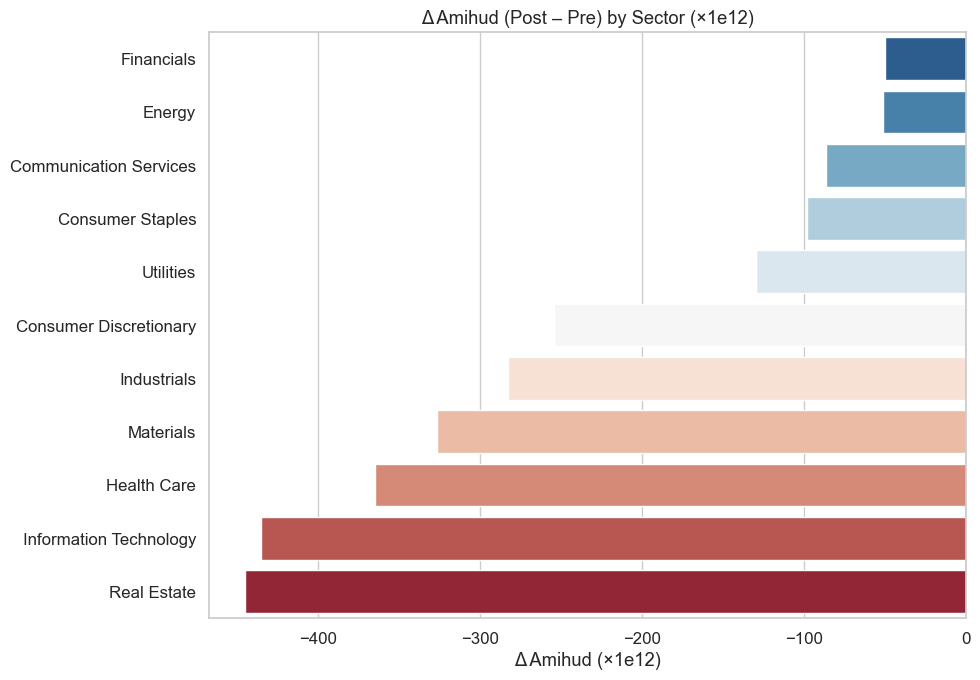

In [81]:
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
import dataframe_image as dfi

# ==== INPUT già nel notebook ====
# - stocks_ante, stocks_post: prezzi (wide, rows=date, cols=tickers)
# - w_mean_pre, w_mean_post: pesi per ticker (Series)
# - firm_data['sector'] o ['Sector']: mappa settori
# - vol_ante, vol_post  (SE NON ESISTONO, verranno derivati da 'comp_volume'/'volumes' se presenti)

sector_map = firm_data['sector'] if 'sector' in firm_data.columns else firm_data['Sector']

# ---- volumi in pezzi (con fallback da un unico DF) ----
vol_ante  = globals().get('vol_ante',  None)
vol_post  = globals().get('vol_post',  None)
vol_all   = globals().get('comp_volume', globals().get('volumes', None))

def _align_both(px: pd.DataFrame, vol: pd.DataFrame):
    idx = px.index.intersection(vol.index)
    cols = px.columns.intersection(vol.columns)
    return px.loc[idx, cols].sort_index(), vol.loc[idx, cols].sort_index()

if vol_ante is None or vol_post is None:
    assert vol_all is not None, "Serve un DataFrame di volumi (es. comp_volume)."
    # riallineo ai due periodi usando gli indici di prezzo
    vol_ante, _ = _align_both(stocks_ante, vol_all)
    vol_post, _ = _align_both(stocks_post, vol_all)

# ---- Amihud per titolo (volumi in PEZZI: denom = P*VolShares) ----
def _amihud_per_stock_shares(px: pd.DataFrame, vol_shares: pd.DataFrame) -> pd.Series:
    px, vol_shares = _align_both(px, vol_shares)
    ret = px.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
    dollar_vol = (px * vol_shares).replace(0, np.nan).replace([np.inf, -np.inf], np.nan)
    am = (ret.abs() / dollar_vol).replace([np.inf, -np.inf], np.nan)
    return am.mean(skipna=True)

amihud_pre_stock  = _amihud_per_stock_shares(stocks_ante, vol_ante).rename('Amihud (Pre)')
amihud_post_stock = _amihud_per_stock_shares(stocks_post, vol_post).rename('Amihud (Post)')
amihud_stock = pd.concat([amihud_pre_stock, amihud_post_stock], axis=1)

# ---- aggregazione settoriale VW (pesi assoluti) ----
def _align_series(*slist):
    idx = None; out = []
    for s in slist:
        s = s[~s.index.duplicated(keep='first')]
        idx = s.index if idx is None else idx.intersection(s.index)
        out.append(s)
    return [s.loc[idx] for s in out]

def _sector_agg(amihud_tbl: pd.DataFrame, w: pd.Series, sector_map: pd.Series) -> pd.DataFrame:
    pre, post, w, sec = _align_series(amihud_tbl['Amihud (Pre)'], amihud_tbl['Amihud (Post)'], w, sector_map)
    df = pd.DataFrame({'sector': sec, 'pre': pre, 'post': post, 'w': w}).dropna()
    def _agg(g):
        ws = g['w'].sum()
        if ws <= 0 or np.isclose(ws, 0.0):
            pre_vw  = g['pre'].mean()
            post_vw = g['post'].mean()
        else:
            pre_vw  = np.average(g['pre'],  weights=g['w'])
            post_vw = np.average(g['post'], weights=g['w'])
        return pd.Series({'Amihud (Pre)': pre_vw, 'Amihud (Post)': post_vw, 'N': len(g)})
    return df.groupby('sector', group_keys=False, sort=True).apply(_agg)

amihud_sector_pre  = _sector_agg(amihud_stock, w_mean_pre,  sector_map)
amihud_sector_post = _sector_agg(amihud_stock, w_mean_post, sector_map)

amihud_sector = amihud_sector_pre[['Amihud (Pre)','N']].join(
    amihud_sector_post[['Amihud (Post)']], how='outer'
)
amihud_sector['Δ Amihud'] = amihud_sector['Amihud (Post)'] - amihud_sector['Amihud (Pre)']

# ---- scaling automatico per leggibilità (es. ×1e9 se numeri molto piccoli) ----
def _auto_scale(x: pd.Series):
    med = x.replace(0, np.nan).abs().median()
    if pd.isna(med):
        return 1, ''
    if med < 1e-9:  return 1e12, ' (×1e12)'
    if med < 1e-6:  return 1e9,  ' (×1e9)'
    if med < 1e-3:  return 1e6,  ' (×1e6)'
    if med < 1e-1:  return 1e3,  ' (×1e3)'
    return 1, ''

scale, tag = _auto_scale(amihud_sector[['Amihud (Pre)','Amihud (Post)']].stack())
amihud_sector_scaled = amihud_sector.copy()
amihud_sector_scaled[['Amihud (Pre)','Amihud (Post)','Δ Amihud']] *= scale

# ---- display + export tabella (no Playwright) ----
display_cols = ['Amihud (Pre)','Amihud (Post)','Δ Amihud','N']
styled = (amihud_sector_scaled[display_cols]
          .style.format({'Amihud (Pre)':'{:.6f}','Amihud (Post)':'{:.6f}','Δ Amihud':'{:.6f}','N':'{:,.0f}'})
          .background_gradient(subset=['Δ Amihud'], cmap='coolwarm')
          .set_caption(f'Sector Amihud Illiquidity — Pre vs Post{tag}')
         )

# Mostra in Jupyter
display(styled)

# Salva anche in Excel
amihud_sector_scaled.to_excel('HPx_amihud_sector_table.xlsx')

# ---- barplot Δ Amihud ----
plot_df = amihud_sector_scaled.reset_index().rename(columns={'index':'sector'})
order = plot_df.sort_values('Δ Amihud', ascending=False)['sector']
plt.figure(figsize=(10,7))
sns.barplot(data=plot_df, y='sector', x='Δ Amihud', order=order, palette='RdBu_r')
plt.axvline(0, color='black', ls='--', lw=0.8)
plt.title(f'Δ Amihud (Post – Pre) by Sector{tag}')
plt.xlabel(f'Δ Amihud{tag}')
plt.ylabel('')
plt.tight_layout()
plt.savefig('HPx_amihud_delta_barplot.png', bbox_inches='tight', dpi=300)
plt.show()


In [94]:
# Merge tra Amihud e R² per titolo
cross_df = pd.concat([
    amihud_stock,
    results_REG_pre['R2'].rename('R2 (Pre)'),
    results_REG_post['R2'].rename('R2 (Post)')
], axis=1).dropna()

# Crea le variazioni
cross_df['ΔR2'] = cross_df['R2 (Post)'] - cross_df['R2 (Pre)']
cross_df['ΔAmihud'] = cross_df['Amihud (Post)'] - cross_df['Amihud (Pre)']
cross_df


,Amihud (Pre),Amihud (Post),R2 (Pre),R2 (Post),ΔR2,ΔAmihud
601288 CH Equity,3.790299e-11,2.534222e-11,0.000517,0.077183,0.076666,-1.256078e-11
601398 CH Equity,3.351701e-11,2.214858e-11,0.000007,0.100525,0.100518,-1.136843e-11
600519 CH Equity,1.268989e-11,1.137622e-11,0.147141,0.515475,0.368334,-1.313675e-12
601857 CH Equity,5.536419e-11,4.872213e-11,0.110293,0.346423,0.236130,-6.642056e-12
601988 CH Equity,6.802854e-11,4.430561e-11,0.000190,0.145691,0.145501,-2.372293e-11
...,...,...,...,...,...,...
688262 CH Equity,1.746299e-09,6.355053e-10,0.318675,0.392832,0.074157,-1.110794e-09
688523 CH Equity,4.287804e-09,2.222755e-09,0.267021,0.539738,0.272716,-2.065049e-09
688138 CH Equity,3.268985e-09,1.411477e-09,0.441579,0.427713,-0.013865,-1.857508e-09
688276 CH Equity,1.329258e-09,1.394039e-09,0.304579,0.591791,0.287212,6.478141e-11


In [95]:
import statsmodels.api as sm

X = sm.add_constant(cross_df['ΔAmihud'])
model = sm.OLS(cross_df['ΔR2'], X).fit(cov_type='HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    ΔR2   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     25.10
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           6.45e-07
Time:                        22:12:24   Log-Likelihood:                 508.02
No. Observations:                 998   AIC:                            -1012.
Df Residuals:                     996   BIC:                            -1002.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0691      0.007     10.585      0.0

In [98]:
cross_df['ΔAmihud'].describe()


count    9.980000e+02
mean    -7.333176e-10
std      1.056101e-09
min     -1.418655e-08
25%     -9.023854e-10
50%     -4.071565e-10
75%     -1.562737e-10
max      2.641483e-09
Name: ΔAmihud, dtype: float64

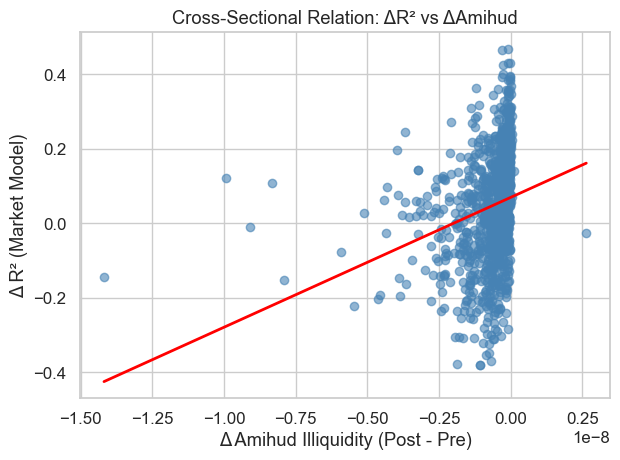

In [100]:
# === ΔR² vs ΔAmihud ===
sns.regplot(
    x='ΔAmihud', y='ΔR2', data=cross_df,
    ci=None,
    scatter_kws={'alpha':0.6, 'color':'steelblue'},
    line_kws={'color':'red', 'linewidth':2}
)

plt.title('Cross-Sectional Relation: ΔR² vs ΔAmihud')
plt.xlabel('Δ Amihud Illiquidity (Post - Pre)')
plt.ylabel('Δ R² (Market Model)')
plt.tight_layout()

# Salva il grafico
plt.savefig('HP2_DeltaR2_vs_DeltaAmihud.png', dpi=300)
plt.show()


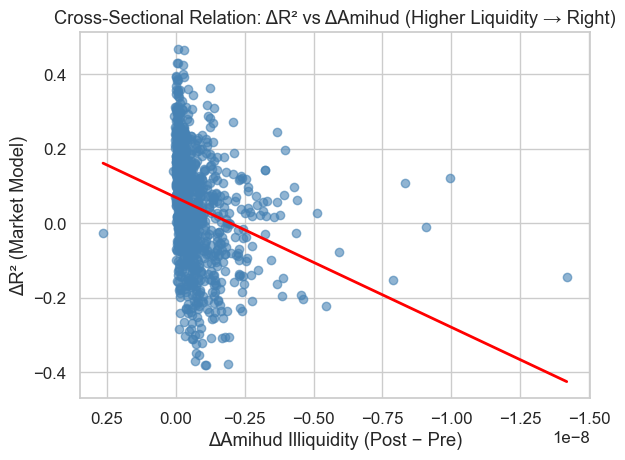

In [104]:
sns.regplot(x='ΔAmihud', y='ΔR2', data=cross_df,
            ci=None, scatter_kws={'alpha':0.6, 'color':'steelblue'},
            line_kws={'color':'red', 'linewidth':2})

plt.gca().invert_xaxis()  # inverti l'asse x
plt.title('Cross-Sectional Relation: ΔR² vs ΔAmihud (Higher Liquidity → Right)')
plt.xlabel('ΔAmihud Illiquidity (Post − Pre)')
plt.ylabel('ΔR² (Market Model)')
plt.tight_layout()
plt.savefig('HP2_DeltaR2_vs_DeltaAmihud_inverted.png', dpi=300)
plt.show()


In [101]:
import statsmodels.api as sm

# === R² Pre vs Amihud Pre ===
X_pre = sm.add_constant(cross_df['Amihud (Pre)'])
y_pre = cross_df['R2 (Pre)']

model_pre = sm.OLS(y_pre, X_pre).fit(cov_type='HC3')
print(model_pre.summary())


                            OLS Regression Results                            
Dep. Variable:               R2 (Pre)   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9460
Date:                Sun, 19 Oct 2025   Prob (F-statistic):              0.331
Time:                        23:02:40   Log-Likelihood:                 621.75
No. Observations:                 998   AIC:                            -1240.
Df Residuals:                     996   BIC:                            -1230.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2935      0.006     51.224   

In [102]:
# === R² Post vs Amihud Post ===
X_post = sm.add_constant(cross_df['Amihud (Post)'])
y_post = cross_df['R2 (Post)']

model_post = sm.OLS(y_post, X_post).fit(cov_type='HC3')
print(model_post.summary())


                            OLS Regression Results                            
Dep. Variable:              R2 (Post)   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     16.88
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           4.30e-05
Time:                        23:03:40   Log-Likelihood:                 564.97
No. Observations:                 998   AIC:                            -1126.
Df Residuals:                     996   BIC:                            -1116.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3563      0.006     60.129

In [103]:
results = pd.DataFrame({
    'Model': ['Pre', 'Post'],
    'Coef_Amihud': [model_pre.params['Amihud (Pre)'], model_post.params['Amihud (Post)']],
    'P_value': [model_pre.pvalues['Amihud (Pre)'], model_post.pvalues['Amihud (Post)']],
    'R_squared': [model_pre.rsquared, model_post.rsquared]
})

results.to_csv('HP2_R2_vs_Amihud_summary.csv', index=False)
display(results)


,Model,Coef_Amihud,P_value,R_squared
0,Pre,2.658749e+06,0.330741,0.000986
1,Post,-2.578827e+07,0.000040,0.014404
